# Analyse de la controverse du "LancetGate" sur Twitter

Auteurs : Simon Guillouet et Emilien Schultz

Date de dernière modification : 6 juin 2023

## Description du notebook

Ce notebook présente les différentes étapes de l'analyse d'un corpus de tweets autour des débats qui ont eu lieu lors de la publication puis de la rétractation d'un article du Lancet en mai 2020 sur l'hydroxychloroquine.

### Plan

####  [1. Présentation du corpus et ciblage](#1)

####  [2. La controverse dans le temps: Fluctuation et commentaire](#2)

####  [3. Un débat viral: Une controverse dominé par des retweets massifs](#3)

####  [4. Des communautés fédérées par la controverse](#4)

####  [5. Une controverse à sens unique](#5)

## Bibliothèques de l'analyse

In [5]:
# Bibliothèques de base
import pandas as pd
from collections import Counter
from statistics import mean 
from datetime import datetime
import numpy as np
from pathlib import Path

# Bibliothèques statistiques & d'analyse de réseau
import pyshs
import networkx as nx
from ipysigma import Sigma
import networkx.algorithms.community as nx_comm

# Bibliothèques pour la construction de graphique
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns

# Extraction des racines URLs
from urllib.parse import urlparse

# On paramètre le notebook pour supprimer l'afficher des messages "Warnings" qui parasitent la visualisation
import warnings
warnings.filterwarnings("ignore")

In [6]:
# On importe un module avec des fonctions créées pour l'occasio permettant d'analyser les clusters identifiés pendant l'analyse:
from Fonctions_AnalysesReseaux import centralite_betweeness, centralite_betweeness_bi,retweets_from,retweets,hashtags_bipartition,hashtags_multipartition, hashtags_multipartition_spe, liens_bipartition_spe 

***Pour rappel la chronologie du Lancet Gate est la suivante***

- **22 mai** The Lancet publie une étude où l’on retrouve les trois mêmes coauteurs faisant état d’une mortalité et d’arythmies cardiaques accrues chez les patients hospitalisés pour Covid-19 et traités par chloroquine ou hydroxychloroquine, associées ou non à des antibiotiques comme l’azithromycine.

- **23 mai** Le directeur général de la santé Jérôme Salomon saisit le Haut Conseil de santé publique (HCSP) pour avis sur l’usage de l’hydroxychloroquine dans le cadre du Covid-19. Sur BFM-TV, l’ancien ministre de la santé Philippe Douste-Blazy émet des doutes sur la qualité de l’étude du Lancet. Le lendemain, le HCSP rend un avis négatif.

- **25 mai** L’Organisation mondiale de la santé (OMS) annonce la suspension provisoire de l’inclusion de patients sous hydroxychloroquine dans son essai clinique Solidarity, destiné à tester plusieurs traitements contre le Covid-19. Dans une vidéo diffusée par son institut marseillais, Didier Raoult qualifie l’étude du Lancet de « foireuse ».

- **26 mai** Mise en circulation d’une lettre ouverte adressée au Lancet et aux coauteurs de l’étude recensant de nombreuses questions méthodologiques.

- **27 mai** Le décret qui permettait l’utilisation de l’hydroxychloroquine pour lutter contre le Covid-19 est abrogé par un nouveau décret. Les essais cliniques français impliquant l’hydroxychloroquine sont suspendus.

- **28 mai** The Lancet apporte un correctif à l’article de Mehra et al., mais indique que ses conclusions restent inchangées. Sapan Desai annonce un audit indépendant sur ses données.

- **2 juin** The Lancet met en garde ses lecteurs (« expression of concern ») sur le fait que « d’importantes questions scientifiques ont été soulevées concernant les données rapportées dans l’article de Mandeep Mehra et ses coauteurs ».

- **4 juin** The Lancet et le NEJM annoncent la rétractation des articles impliquant les données de Surgisphere. L’OMS indique reprendre l’inclusion de patients sous hydroxychloroquine dans son essai Solidarity : l’examen des données n’a pas mis en évidence sa toxicité.

<a id='1'></a>


## 1. Le Corpus de Tweet


Le corpus de tweets utilisé pour cette analyse a été récupéré via l'API Twitter courant juin 2020, avec les outils du médialab (tweets mentionnant certains mots clés + les threads antérieurs). Il compte environ 1 500 000 tweets dans toutes les langues postés entre 2015 et juillet 2020.

In [7]:
# chargement des données brutes
path_data_brut = Path("./0.Input/bd_tweet_total.csv")
data_complet = pd.read_csv(path_data_brut, encoding='utf-8-sig')

data_complet['created_at'] = pd.to_datetime(data_complet['created_at'], errors='coerce') # Format date

**Langues**

Le Français, deuxième langue la plus utilisée pendant la controverse.

In [6]:
pd.DataFrame(Counter(data_complet["lang"]).most_common(10), columns=['Langue', 'Nombre de tweets'])

,Langue,Nombre de tweets
0,en,639009
1,fr,535221
2,pt,142537
3,es,73675
4,und,43770
5,ja,29096
6,nl,14123
7,it,12509
8,tr,7740
9,ar,5844


Des tweets postés entre 2015 et 2020

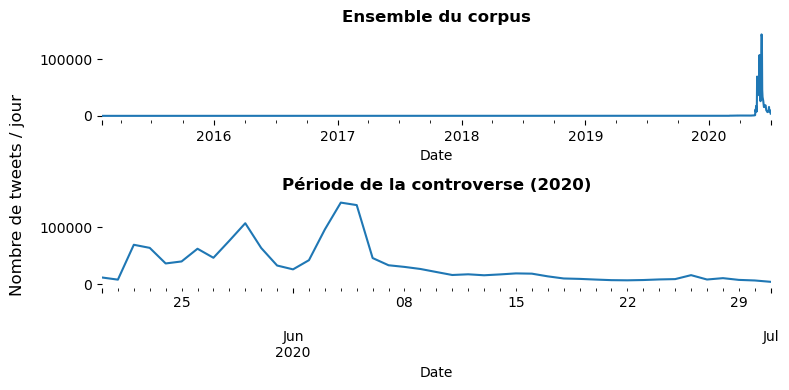

In [7]:
fig, ax = plt.subplots(2,1,figsize=(8, 4),sharey=True,sharex=False)

d = data_complet.groupby(\
              pd.Grouper(key='created_at', freq='D')).size()

d.plot(ax=ax[0])
d.plot(ax=ax[1])

ax[1].set_xlim('2020-05-20','2020-07-01')

ax[0].set_title("Ensemble du corpus",fontweight="bold")
ax[1].set_title("Période de la controverse (2020)",fontweight="bold")

ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

fig.supylabel('Nombre de tweets / jour')

plt.tight_layout()

**Ressérer la problématique: Tweets francophones et rétrécissement de la période d'étude**

Nous avons réduit le corpus initial en tenant compte de deux critères:
- Nous souhaitons centrer l'étude sur le cœur de la controverse afin d'éviter d'intégrer des tweets ne portant sur notre sujet d'étude. Nous avons donc retenu la période du 20 mai 2020 au 11 juin 2020 soit deux jours avant la publication de l'article (22 mai) et une semaine après le retrait de ce dernier (4 juin).
- Nous n'analyserons que les tweets francophones dans un double souci de simplifier l'analyse des textes mais aussi pour mettre en exergue les spécificités du débat Français.

In [8]:
# Tweets en FRANCAIS uniquement
data = data_complet[(data_complet.lang == "fr")]

# Conservation des données entre le 20 mai et le 11 juin 2020
data['date'] = pd.to_datetime(data['created_at']).dt.date
mask = (data['date'] >= pd.to_datetime('2020-05-20').date() ) & (data['date'] <= pd.to_datetime('2020-06-11').date() )
data = data.loc[mask]

# On procède à plusieurs modification pour simplifier l'analyse
data['nb_1'] = 1  #Pour réaliser rapidement des calculs de Groupby et autre

data['RT'] = data['retweeted_user_name'].notnull() # On Ajoute des colonnes pour déterminer si le Tweet est un RT, une REPONSE, une CITATION

data['RT_nb'] = 0
data.loc[data['retweeted_user_name'].notnull(), 'RT_nb'] = 1

data['REP_nb'] = 0
data.loc[data['to_user_name'].notnull(), 'REP_nb'] = 1

data['Q_nb'] = 0
data.loc[data['quoted_user_name'].notnull(), 'Q_nb'] = 1

# suppression du dataset brut pour la mémoire
del data_complet

# Reset de l'index
data = data.reset_index(drop=True)

In [9]:
"Le corpus étudié compte {} tweets postés par {} comptes uniques.".format(len(data),data['from_user_name'].nunique() )

'Le corpus étudié compte 490094 tweets postés par 69309 comptes uniques.'

<a id='2'></a>

## 2. La controverse dans le temps

La controverse du lancetgate débute le 22 mai avec la publication de l'article “Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis” à 12h29. Le premier tweet y faisant référence est un tweet de "AlexisDeLancer" déclarant *"L'hydroxychloroquine et la chloroquine liées à un risque accru de décès selon une étude et publiée aujourd'hui par @TheLancet. L'étude a été menée auprès de 96 000 patients ayant contracté le #coronavirus https://www.washingtonpost.com/health/2020/05/22/hydroxychloroquine-coronavirus-study/"*. La nouvelle de la diffusion de l'article met environ 24h a réellement se diffuser car le premier pic notable date du 23 mai. On constate par la suite un premier plateau de cinq jours avec un rythme de 200 à 300 000 tweets quotidien, marqué par la diffusion de la première contestation officielle de la communauté scientifique le 26 mai avec la lettre ouverte supervisée par James Watson. 

Le pic de la polémique est atteint le 28, 29 et 30 mai avec plus de 500 000 tweets journaliers, au moment de la première correction officielle apporté par les auteurs à la demande du Lancet. On constate une décrue soudaine avant un dernier pic le 2,3 et 4 juin correspondant à la notification par le Lancet d'une "Expression of concern" le 2 avant le retrait définitif le 4.

La semaine suivant le retrait de l'article est caractérisée par un reflux continue faisant tendre le nombre de tweets sur le sujet vers zéro.

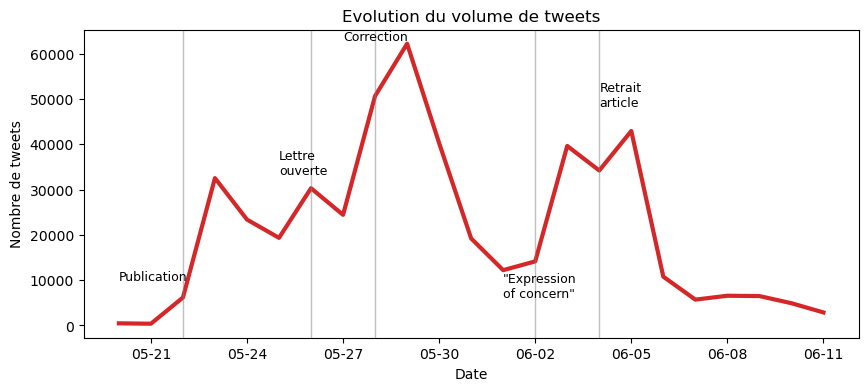

In [10]:
# Graphique sur l'évolution du nombre de Tweets pendant la controverse
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(data['date'].value_counts().sort_index(), axes=ax, linewidth=3, color='C3')

plt.axvline(datetime(2020, 5, 22), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 5, 26), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 5, 28), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 6, 2), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 6, 4), linewidth=1, color='grey', alpha=0.5)

ax.annotate('Publication', xy=(datetime(2020, 5, 20), 10000), fontsize=9)
ax.annotate('Lettre\nouverte\n', xy=(datetime(2020, 5, 25), 30000), fontsize=9)
ax.annotate('Correction', xy=(datetime(2020, 5, 27), 63000), fontsize=9)
ax.annotate('"Expression\nof concern"\n', xy=(datetime(2020, 6, 1),3000), fontsize=9)
ax.annotate('Retrait\narticle\n', xy=(datetime(2020, 6, 4), 45000), fontsize=9)

half_year_locator = mdates.DayLocator(interval=3) #Interval de dates
ax.xaxis.set_major_locator(half_year_locator) #Interval de dates

dfmt = DateFormatter("%m-%d") # Formatage de la date
ax.xaxis.set_major_formatter(dfmt) # Formatage de la date

ax.set_xlabel("Date")
ax.set_ylabel("Nombre de tweets") 
plt.title("Evolution du volume de tweets", loc='Center', fontsize=12, fontweight=0, color='black');

Il est intéressant de constater que le pic du nombre de tweet n'est pas atteint au moment du retrait  de l'article mais avant, quand la controverse est en cours et que l'incertitude demeure sur la véracité des conclusions de l'article. La suspicion, le doute et le processus de production des discours semblent plus générateur de tweets que le fait que la question soit tranchée malgré les problèmes de fond qu'elle soulève.

<a id='3'></a>


## 3. Un débat viral

L'une des caractéristiques majeures de la controverse du LancetGate est la proportion de retweets très au-dessus de la moyenne. Habituellement, la part des retweets dans l'ensemble des discussions sur twitter est de 50% (référence). Cette proportion est ici de 72% ne laissant aux "tweets originaux" qu'une modeste part de 28%. L'ensemble des autres interactions sur twitter sont donc largement dominées, que ce soit les débats sous la forme de chaînes de réponses, de citations ou simplement de tweets classiques.

In [16]:
# Proportion de Retweets
"Les {} retweets représentent {}% de l'ensemble du corpus".format(data["RT_nb"].sum(),
                                                         round( ( (data["RT"]).sum() / len(data))*100,1) )          

"Les 350819 retweets représentent 71.6% de l'ensemble du corpus"

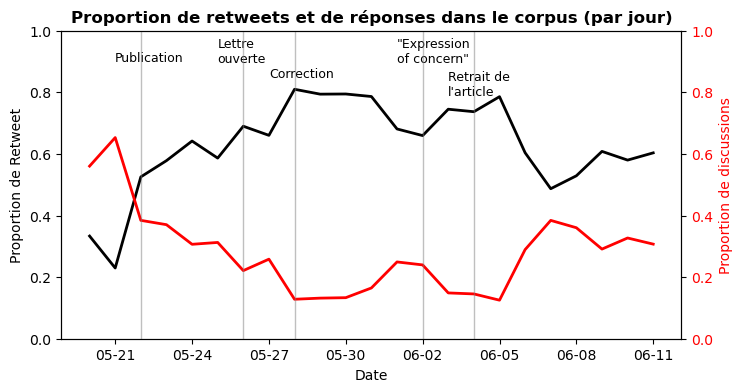

In [11]:
# Evolution de la part des RT dans les tweets globaux:
fig, ax1 = plt.subplots(figsize=(8,4))

ax2 = ax1.twinx()
ax1.set_ylim(0, 1)  
ax2.set_ylim(0, 1)

ax1.plot(data[data.RT==True]['date'].value_counts().sort_index() / data['date'].value_counts().sort_index(), color="black",linewidth=2)
ax2.plot(data[data.REP_nb==1]['date'].value_counts().sort_index() / data['date'].value_counts().sort_index(), color="red",linewidth=2)

plt.axvline(datetime(2020, 5, 22), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 5, 26), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 5, 28), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 6, 2), linewidth=1, color='grey', alpha=0.5)
plt.axvline(datetime(2020, 6, 4), linewidth=1, color='grey', alpha=0.5)

ax1.annotate('Publication', xy=(datetime(2020, 5, 21), 0.9), fontsize=9)
ax1.annotate('Lettre\nouverte\n', xy=(datetime(2020, 5, 25), 0.85), fontsize=9)
ax1.annotate('Correction', xy=(datetime(2020, 5, 27), 0.85), fontsize=9)
ax1.annotate('"Expression\nof concern"\n', xy=(datetime(2020, 6, 1),0.85), fontsize=9)
ax1.annotate("Retrait de\nl'article\n", xy=(datetime(2020, 6, 3), 0.74), fontsize=9)

half_year_locator = mdates.DayLocator(interval=3) #Interval de dates
ax1.xaxis.set_major_locator(half_year_locator) #Interval de dates

dfmt = DateFormatter("%m-%d") # Formatage de la date: sans l'année
ax1.xaxis.set_major_formatter(dfmt) # Formatage de la date: sans l'année

ax1.set_ylabel("Proportion de Retweet", color= "black")
ax1.tick_params(axis="y", labelcolor="black")
ax2.set_ylabel("Proportion de discussions", color = "red")
ax2.tick_params(axis="y", labelcolor="red")

ax1.set_xlabel("Date")
plt.title("Proportion de retweets et de réponses dans le corpus (par jour)", loc='Center', fontsize=12,fontweight="bold", color='black');

**Un débat dominé par un groupe restreint**

On constate rapidement que les retweets sont massivement le fait d'un petit nombre de comptes très influent: 348 comptes ont plus de 100 RT cumulés et 71 en ont plus de 1000. Ces personnes sont les principaux "passeurs" du débat dans le contexte Français:
- Les 10 comptes les plus RT comptent pour 20% de tous les tweets (101k)
- Les 30 comptes les plus RT comptent pour 27% de tous les tweets (132k)
- Les 100 comptes les plus RT comptent pour 50% de tous les tweets (236k)

In [12]:
# Nombre total de compte RT
"Il y a {} retweets de {} tweets originaux fait par {} comptes".format(data["RT_nb"].sum(),
                                                                      data[data.RT == True].groupby('text')['RT_nb'].sum().count(),
                                                                      len(data.groupby('retweeted_user_name')['nb_1'].sum()))

'Il y a 350819 retweets de 21042 tweets originaux fait par 6943 comptes'

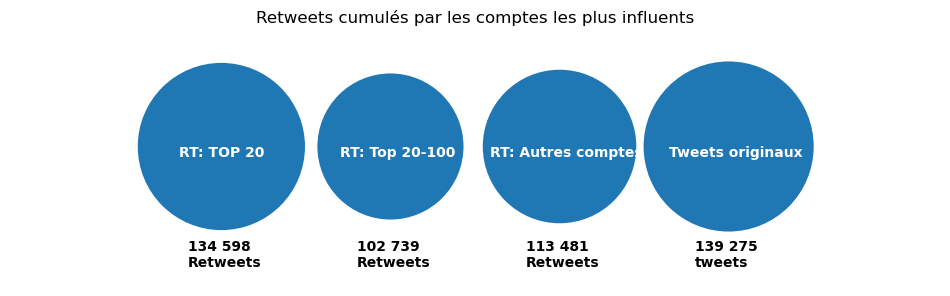

In [13]:
# Graphique de visualisation
r20 = data.groupby('retweeted_user_name')['nb_1'].sum().sort_values(ascending=False)[0:20].sum()
r100 = data.groupby('retweeted_user_name')['nb_1'].sum().sort_values(ascending=False)[20:100].sum()
r500 = data.groupby('retweeted_user_name')['nb_1'].sum().sort_values(ascending=False)[100:-1].sum()
r_NoRT = len(data[data.RT == False])

r_1 = [0,r20,r100,r500,r_NoRT,0]
x = [0,1,2,3,4,5]

plt.subplots(figsize=(12,3))

sns.scatterplot(x=x, y=1, size=r_1, legend=False, sizes=(0, 15000),markers=False)
sns.despine(left=True, bottom = True)

plt.tick_params(labelleft=False, left=False)
plt.tick_params(labelbottom=False, bottom=False)
plt.text(x=0.75, y=0.995, s="RT: TOP 20", color="white", fontweight="bold")
plt.text(x=1.7, y=0.995, s="RT: Top 20-100", color="white", fontweight="bold")
plt.text(x=2.59, y=0.995, s="RT: Autres comptes", color="white", fontweight="bold")
plt.text(x=3.65, y=0.995, s="Tweets originaux", color="white", fontweight="bold")

plt.text(x=0.80, y=0.935, s="134 598\nRetweets\n", color="black",fontsize=10, fontweight="bold")
plt.text(x=1.80, y=0.935, s="102 739\nRetweets\n", color="black",fontsize=10, fontweight="bold")
plt.text(x=2.8, y=0.935, s="113 481\nRetweets\n", color="black",fontsize=10, fontweight="bold")
plt.text(x=3.80, y=0.935, s="139 275\ntweets\n", color="black",fontsize=10, fontweight="bold")

plt.title("Retweets cumulés par les comptes les plus influents", loc='Center', fontsize=12, fontweight=0, color='black')

plt.show() 

**Des leaders d'opinions peu connus**

In [3]:
path_auteurs50 = Path("./0.Input/auteurs_50.csv")
auteurs = pd.read_csv(path_auteurs50, encoding='utf-8-sig', sep=";")

Le profil des personnes les plus retweetées mérite une attention particulière. Pour ce faire nous avons recherché les 50 personnes les plus retweetées et renseigné leur profil manuellement.

Les comptes les plus populaires et les plus centraux appartiennent peu à des structures comme des entreprises, institutions publiques, médias (7) mais surtout à des individus (43). Parmi ces individus, on ne trouve que six personnes pouvant être considérées comme scientifiques ou appartenant au monde médical. La plupart d'entre eux sont des "anonymes" dont on ne retrouve la trace nulle part (14) ou des "quasi anonymes" avec une très faible notoriété. Ils n'en demeurent pas moins que ces personnes ont été créditées d'une confiance et d'une pertinence par la twittosphère qui ont fait défaut à des figures habituellement centrales dans les controverses scientifiques: experts, médias, personnalités politique, représentants de la société civile etc.

In [82]:
# Profil des 50 auteurs les plus retweetés
pyshs.tri_a_plat(auteurs,"type")

,Effectif,Pourcentage (%)
Organisation,6.0,12.0
Personne,44.0,88.0
Total,50.0,100.0


In [83]:
# Profil des 50 auteurs les plus retweetés
pyshs.tri_a_plat(auteurs,"soustype_personne")

,Effectif,Pourcentage (%)
Journaliste,2.0,4.4
Journaliste / Intellectuel,14.0,31.1
Juriste,1.0,2.2
Personnalité politique,8.0,17.8
Personne inconnue,12.0,26.7
Professionnel sante / Scientifique,7.0,15.6
Société civile,1.0,2.2
Total,45.0,100.0


Liste de 30 comptes les plus retweetés:

Text(0.5, 1.0, 'Les 30 comptes les plus Retweetés')

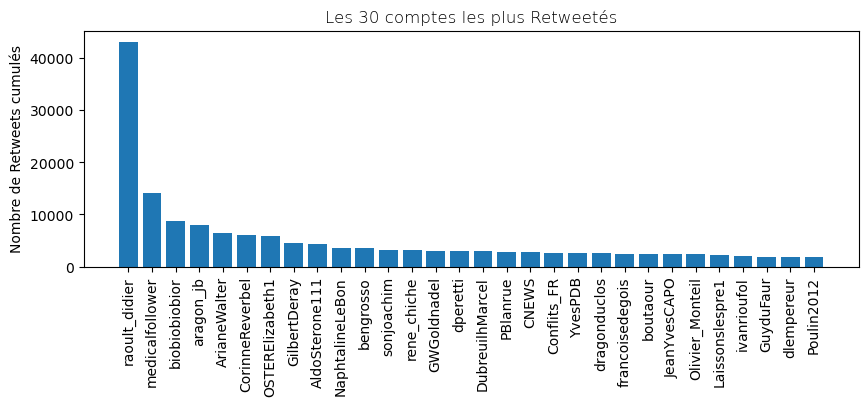

In [291]:
db_rt_user = data.groupby('retweeted_user_name')['nb_1'].sum()

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(x =db_rt_user.sort_values(ascending=False)[0:30].index , height = db_rt_user.sort_values(ascending=False)[0:30])
plt.xticks(rotation=90) 

plt.subplots_adjust(bottom=0.4, top=0.99)

ax.set_ylabel("Nombre de Retweets cumulés") 
plt.title("Les 30 comptes les plus Retweetés", loc='Center', fontsize=12, fontweight=0, color='black')

**L'importance de Didier Raoult**:

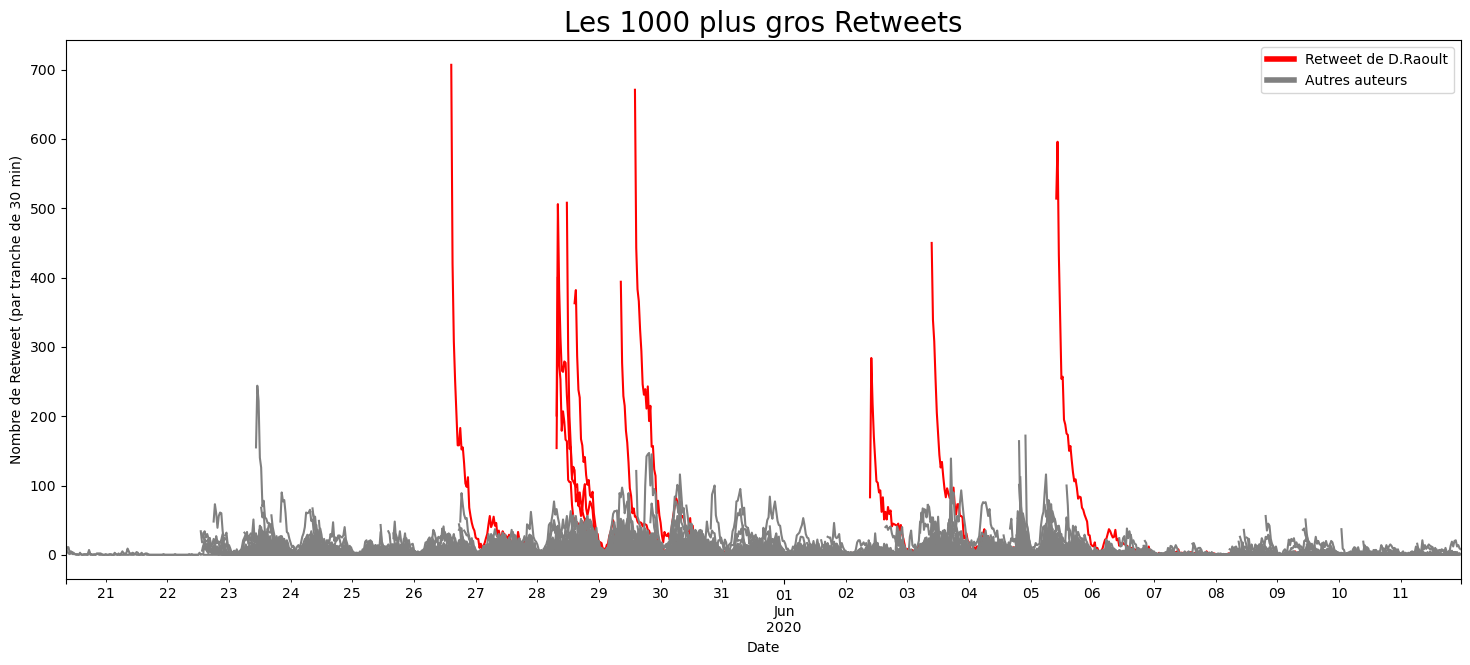

In [231]:
topretweets = data.groupby('text').size().sort_values(ascending=False).reset_index()

plt.figure(figsize=(18,7))
for top in range(0,1000):
    tweetid = topretweets.iloc[top].text
    Auteur = data[data.text == tweetid]["retweeted_user_name"].unique()[0]
    if Auteur == 'raoult_didier':
        Couleur_x = "red"
    else: 
        Couleur_x = "grey"
    
    top_retweets = data[data.text==tweetid]
    top_retweets.groupby(\
                                       pd.Grouper(key='created_at', freq='30min')).size().plot(color=Couleur_x)

# Légende
legend_elements = [Line2D([0], [0], color='red', lw=4, label='Retweet de D.Raoult'),
                       Line2D([0], [0], color='grey', lw=4, label='Autres auteurs')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Date')
plt.ylabel('Nombre de Retweet (par tranche de 30 min)')
plt.title('les 1000 tweets les plus retweetés', fontsize = 20)
plt.show();

<a id='4'></a>


## 4. Des communautés diverses mais fédérées par la controverse

Nous avons souhaité affiner ces analyses générales en proposant une division des participants de la controverse en communautés et ce pour trois raisons:
- Déterminer le nombre de communautés: constate-t-on une bipartition ou une multipartition plus complexe ?
- Identifier les spécificités de chaque communautés
- Temporiser les évolutions des communautés pour mieux analyser la controverse dans le temps. 

Pour ce faire nous utiliserons les outils d'analyse des réseaux. Nous créons un graph dans lequel les utilisateurs sont les nœuds et les liens représentent les Retweets. Plus un nœud a de liens, plus ce compte a été retweeté par des comptes différents. La taille de chaque nœud est proportionnelle au nombre total de tweets et de retweets (actions du compte).

Cela implique de faire l'hypothèse qu'un retweet est la plupart du temps une marque de soutien, une volonté de diffuser dans l'espace public un discours avec lequel on est en accord. A l'inverse des autres interactions (citation, réponses, mentions), le retweet est très souvent une marque de soutien (référence nécessaire). Ce n'est évidemment pas systématique, et l'enjeu est surtout d'identifier les grandes structures de diffusion. Celles-ci sont aussi largement influencées par les algorithmes de visibilité de la plateforme dans les fils. En faisant l'hypothèse que les personnes retweetant les mêmes personnes partagent globalement les mêmes opinions et ont au minimum une certaine proximité de point de vue sur un sujet, nous serons en mesure de diviser les nœuds de notre réseau en communautés, communautés formées par des utilisateurs retweetant les mêmes personnes.

In [4]:
# Création du réseau de retweet

network_retweets = nx.Graph()

##  Pour information: 
# utilisateur = 1 compte
# utilisateur["weight"] = Nombre de tweet de l'utilisateur
# retweet_utilisateur = Personne retweetée (au moins 1 fois)
# edges: Nombre de RT fait par utilisateur du compte retweet_utilisateur

# On fait une boucle pour chaque tweet du corpus
for i, line in data.iterrows():
    
    # Nom du compe ayant tweeté
    utilisateur = str(line["from_user_name"])
    
    # L'utilisateur est-il déjà dans le réseau ?
    if not utilisateur in network_retweets.nodes:
        # S'il n'y est pas, on l'ajoute avec un poids de 1
        network_retweets.add_node(utilisateur, label=utilisateur, weight=1)
    else:
        # S'il l'est, on augmente son poids de 1
        network_retweets.nodes[utilisateur]["weight"] += 1    

    # Si le tweet est un retweet
    if pd.notnull(line["retweeted_user_name"]):

        # on extrait le nom de l'auteur original du tweet 
        retweet_utilisateur = str(line["retweeted_user_name"])
        
        # si cet auteur original n'est pas dans le réseau
        if not retweet_utilisateur in network_retweets.nodes:
            # on ajoute un noeud
            network_retweets.add_node(retweet_utilisateur, label=retweet_utilisateur, weight=0)

        # s'il y a un retweet
        if pd.notnull(retweet_utilisateur):
            
            # si l'arrête entre l'utilisitateur et l'auteur original du tweet n'existe pas
            if not network_retweets.has_edge(utilisateur, retweet_utilisateur):
                # On créé cette arrête
                network_retweets.add_edge(utilisateur, retweet_utilisateur, weight=1)
            else:
                # si elle existe déjà on on augmente son poids de 1
                network_retweets[utilisateur][retweet_utilisateur]["weight"] += 1 

# Création du sous-graphe de la composante principale (sur laquelle on se concentre)
list_subgraph = list(nx.connected_components(network_retweets))
list_subgraph.sort(key=len, reverse=True)
connected_graph = network_retweets.subgraph(list_subgraph[0])

Pour réduire la taille du code, certaines fonctions de traitement ont été mises sous la forme d'un module dédié : `Fonctions_AnalysesReseaux`

Avant toute analyse, on constate qu'il existe d'un côté un groupe relativement important d'isolats (comptes n'ayant pas fait un seul RT et sans connexion) et un ensemble de nombreux petits graphs de quelques dizaines de nœuds qui sont déconnectés du reste. Le reste forme un grand groupe de plus de 55 000 personnes qui constituent 80% de tous les comptes. Ce groupe est le centre de l'activité Twitter concernant la controverse du Lancet. Il est aussi possible que les isolats et groupes déconnectés soient simplement la conséquence de l'existence d'autres conversions sur le "lancet" parallèlement au débat central.

In [93]:
print("Le graph a",nx.number_of_isolates(network_retweets), "isolats")

Le graph a 12889 isolats


In [94]:
# Nombre de sous réseaux
list_subgraph = list(nx.connected_components(network_retweets))
list_subgraph.sort(key=len, reverse=True)
print("Nombre de sous réseaux isolés:", (len(list_subgraph) - nx.number_of_isolates(network_retweets)))  # 411 sous graphs (hormis les isolats)

Nombre de sous réseaux isolés: 411


In [95]:
 # Le sous réseau le plus gros
print("Le sous réseau le plus gros a", len(list_subgraph[0]), "noeuds")

Le sous réseau le plus gros a 55391 noeuds


**Densité**:

Ce grand graph connexe de 55 000 nœuds est très peu dense ce qui signifie que de nombreuses personnes n'interagissent pas entre elles. Cela est normal dans un réseau social comme Twitter ou chaque personne se constitue sa propre communauté et ne voient pas ou ne souhaitent pas interagir avec les autres communautés. 

In [29]:
## CENTRALITE de degré (ou DENSITE): Nombre de liens existant par rapport a tous les liens possibles.
"La densité du réseau est très faible que ce soit le réseau intégral ({}) ou le réseau connexe ({}).".format(round(nx.density(network_retweets),5),
                                                                                                                                        round(nx.density(connected_graph),5))

'La densité du réseau est très faible que ce soit le réseau intégral (0.0001) ou le réseau connexe (0.00016).'

### B. PARTITION EN CLUSTERS

Après cette analyse descriptive, nous pouvons diviser les différents nœuds en communauté. Nous nous baserons pour ce faire sur le réseau des retweets. Nous utilisons pour ce faire l'algorithme de Louvain qui permet de diviser les nœuds d'un réseau. Pour cela nous avons ajuster le paramètre "résolution" de l'algorithme de Louvain à 1, la valeur par défaut qui maximise la modularité et qui permet d'obtenir un plus grand nombre de clusters.

In [5]:
# On génénère la clusterisation avec l'algorithme de Louvain
cluster_multiples = nx_comm.louvain_communities(connected_graph, weight='weight', 
                                                resolution=1, threshold=1e-07, seed=123)
# Trier du plus grand au plus petit
cluster_multiples = sorted(cluster_multiples,key=len,reverse=True)

# Liste des clusters
liste_clusters = pd.Series([len(i) for i in sorted(cluster_multiples)])

# Regroupement des clusters après le rang 7
cluster8 = set()
for i in cluster_multiples[8:]:
    cluster8.update(i)

# Liste des clusters
cluster_7 =  cluster_multiples[0:7] + [cluster8]

In [111]:
# Nombre de clusters
print("il y a au total",len(liste_clusters), "clusters dans cette partion")

il y a au total 54 clusters dans cette partion


In [112]:
# Modularité
print("La modularité de la clusterisation multipartite est meilleure, elle est égale à",round(nx_comm.modularity(connected_graph,nx_comm.louvain_communities(connected_graph, weight='weight', resolution=1, threshold=1e-07, seed=123)),2))

La modularité de la clusterisation multipartite est meilleure, elle est égale à 0.37


La clusterisation multipartite semble de bonne qualité. La modularité est relativement élevée (0,37) signe que les groupes constitués sont relativement homogènes. Cette partition aboutit à une division en 54 clusters mais un grand nombre d'entre eux sont très petits (quelques dizaines ou centaines de nœuds). Nous avons décidé de regrouper tous les petits clusters dans un cluster "Autre". Ce regroupement permet d'aboutir à une partition en 8 clusters: 7 clusters dont la taille varie de 12900 nœuds à 2400 nœuds et un cluster "Autre" regroupant l'ensemble des autres clusters.

In [12]:
# Effectifs par cluster
for x in cluster_7 :
    print(f"Cluster n° {cluster_7.index(x)} : {len(x)} comptes ({round( (len(x)/53963)*100 ,1)}%)")

Cluster n° 0 : 12890 comptes (23.9%)
Cluster n° 1 : 11420 comptes (21.2%)
Cluster n° 2 : 7606 comptes (14.1%)
Cluster n° 3 : 7507 comptes (13.9%)
Cluster n° 4 : 5206 comptes (9.6%)
Cluster n° 5 : 4136 comptes (7.7%)
Cluster n° 6 : 2400 comptes (4.4%)
Cluster n° 7 : 2798 comptes (5.2%)


**Visualisation du réseau**

In [122]:
# On personnalise les couleurs de chaque cluster

# On créé une liste de couleur dans le mêmre ordre que les clusters dans la liste de liste 'cluster_7'
couleurs_cluster = ['forestgreen','darkgoldenrod','saddlebrown','crimson','darkorange','orchid','darkcyan','lightgrey']
couleur_7 = {} # On créé un dictionnaire vide qui stockera le noeud et sa couleur

for user in connected_graph.nodes: # On sélectionne chaque USER
    for cluster in cluster_7:
        if user in cluster: # On regarde son cluster d'appartenance
            couleur_7[user] = couleurs_cluster[cluster_7.index(cluster)] # On lui attibut une couleur dans la liste couleurs_cluster

In [ ]:
# Visualisation interractive
Sigma(connected_graph,
      raw_node_color=couleur_7 , node_size = connected_graph.degree, node_size_range=(1.5,20),
      default_edge_color = "white",
      default_node_label_color = "black",
      node_zindex = connected_graph.degree,
      default_node_label_size = 16,
      raw_node_label  = noeuds_centraux_degres.keys())

***Rendu statique pour le notebook - utiliser ipysigma pour le rendu interactif***

<div>
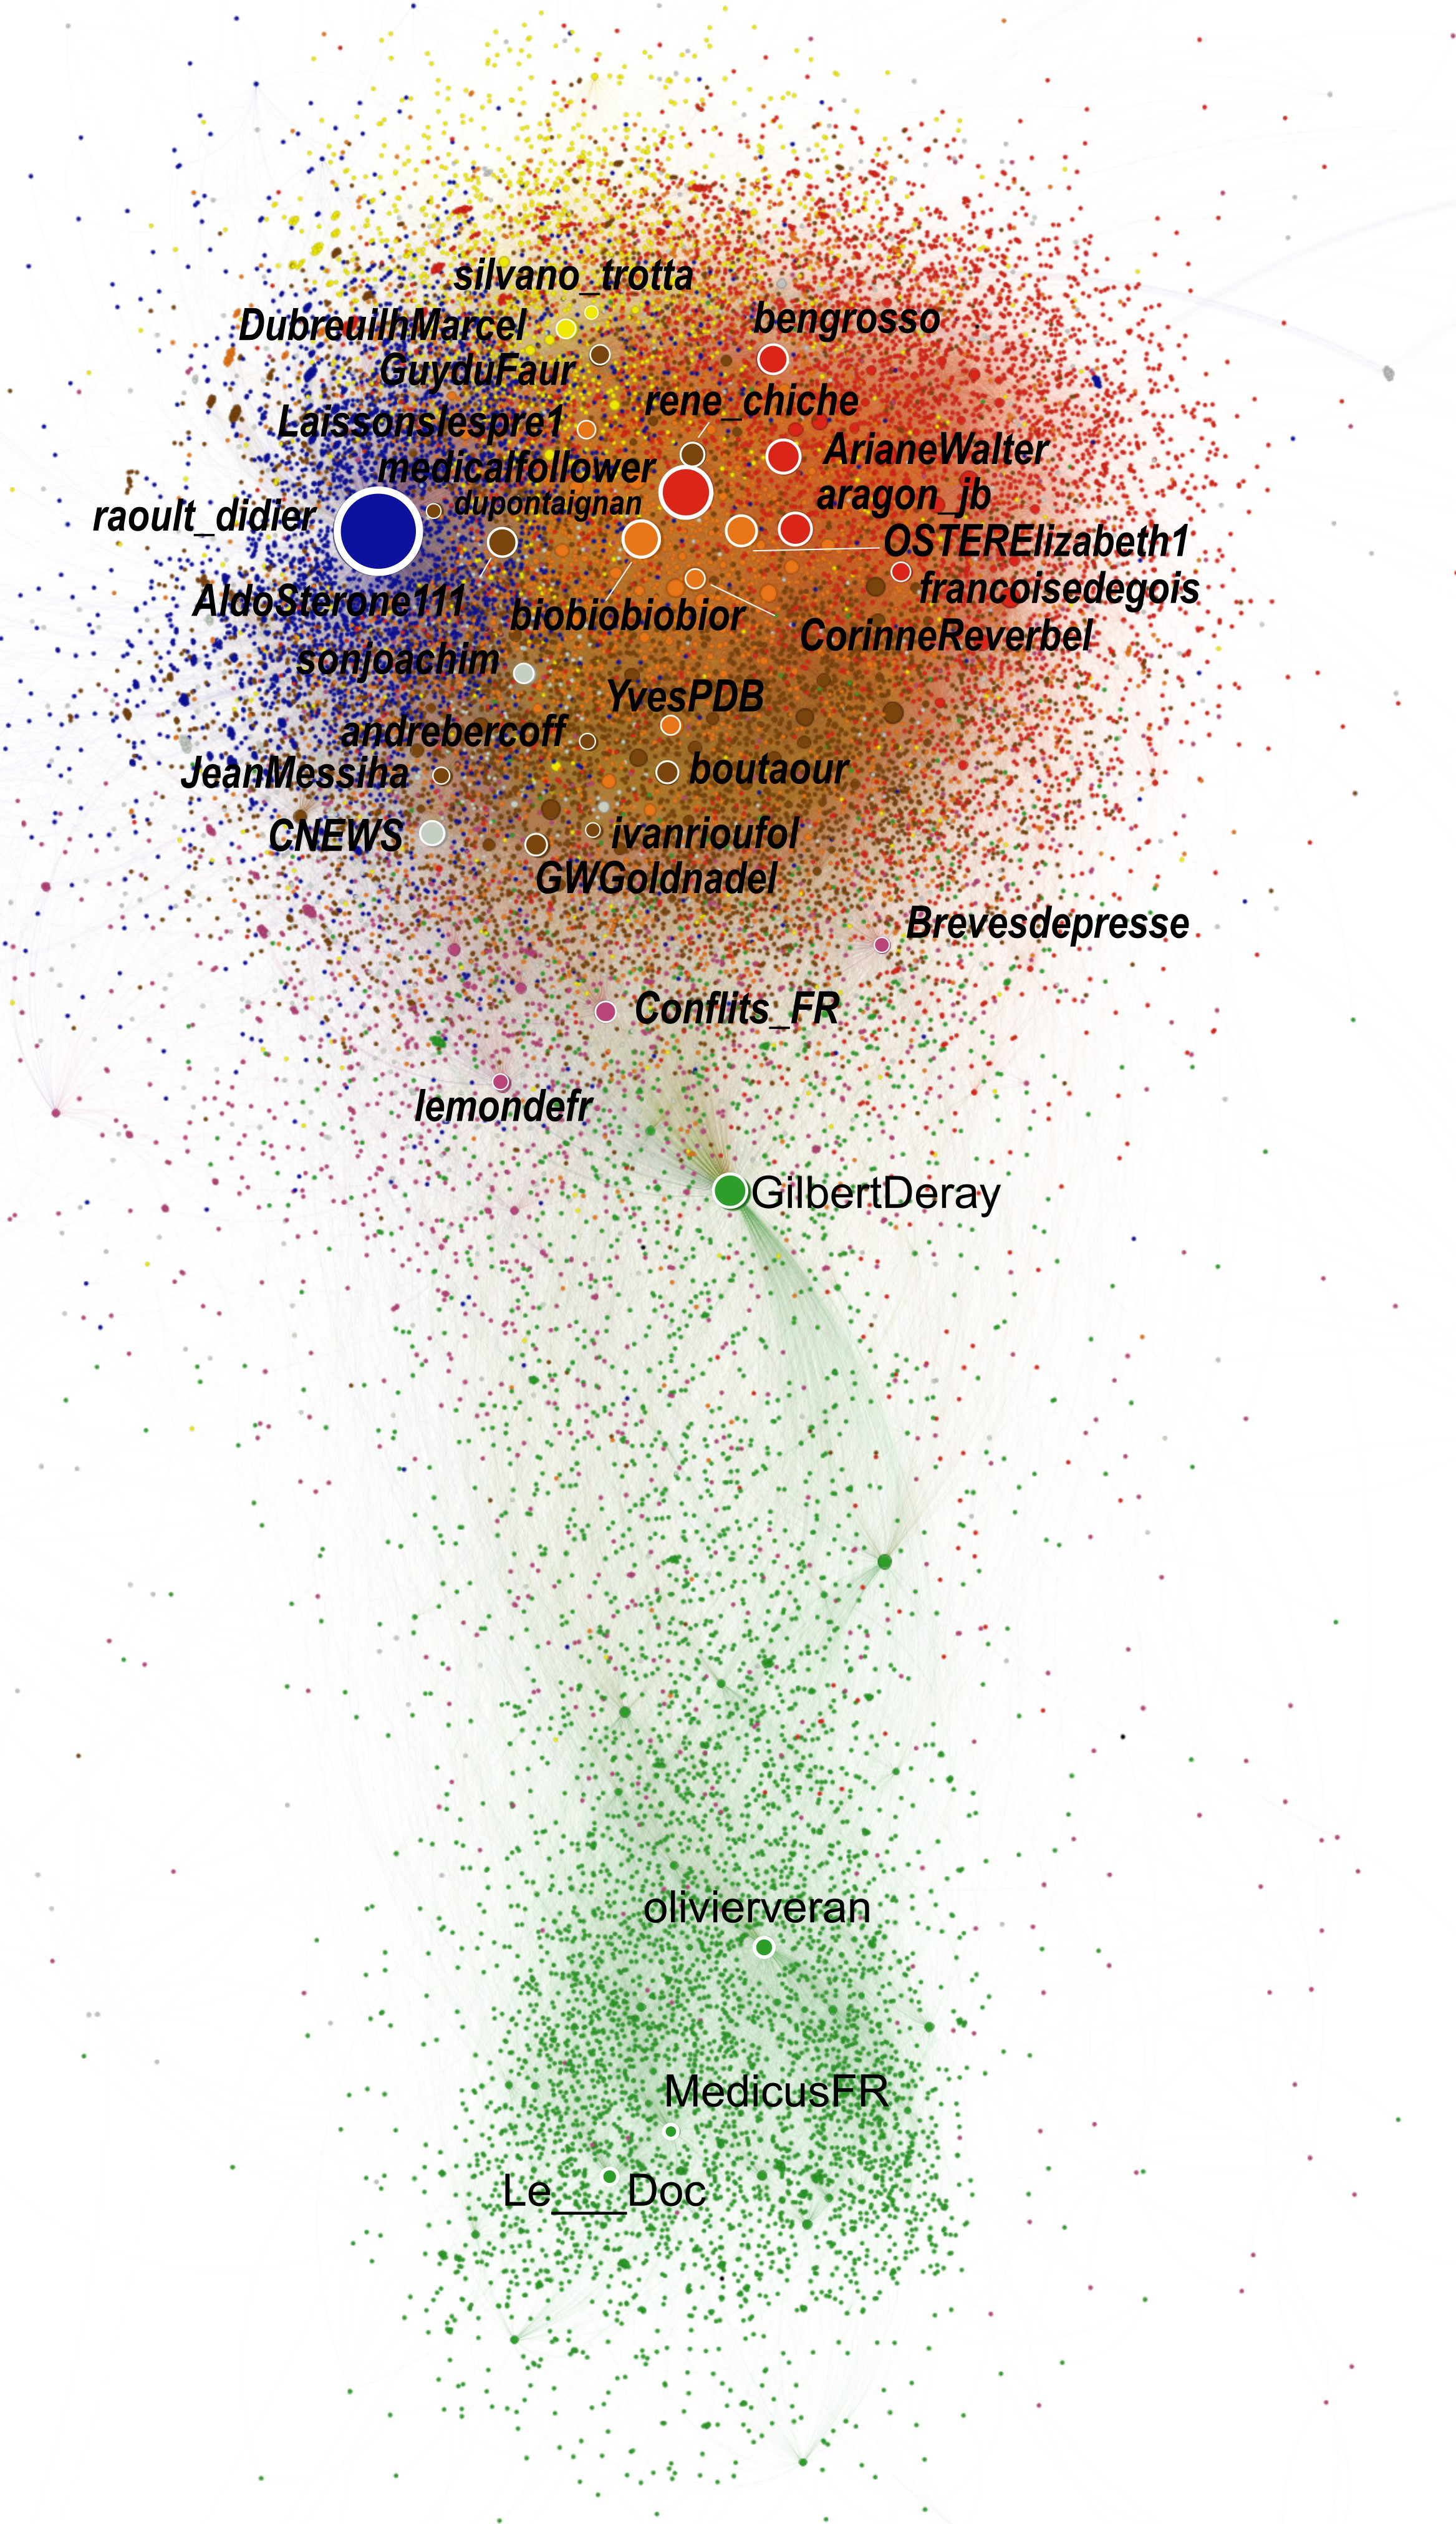
</div>

### C. Caractériser les clusters

La clusterisation effectuée, il convient à présent de les caractériser, de tenter de les situer, de comprendre leurs discours, leurs sujets d'intérêts, leurs affinités et de déterminer ce qui les oppose et les différencie. 

Pour ce faire nous allons procéder de plusieurs façons. 

1 - Nous observons dans un premier temps qui composent ces clusters et qui sont les personnes les plus influentes de chaque clusters. 

2 - Nous analyserons le contenu des tweets les plus populaires de chaque cluster. Nous utiliserons le produit d'une classification manuelle des 1000 les tweets les plus retweetés où a été consignée la présence / l'absence de certains sujets précis. Nous verrons comment les clusters se différencient en fonction de leur plus grand intérêt pour certains sujets.

3 - Nous compilerons les hashtags et les liens URLS associés à chaque cluster qui peuvent donner un certain nombre d'indications: quels thèmes mettent-ils avant ? Quelles sont leurs sources et leurs références ?

4- Nous identifierons les communautés les plus actives où se trouvent les comptes faisant le plus de tweets et celles ayant le plus gagné de followers (donc d'audience).

**On attribue aux données initiales, leur cluster d'appartenance** :

Pour produire des statistiques sur notre corpus nous intégrons les résultats de la partition de Louvain dans le jeu de données. Pour chaque Tweet, nous attribuons le numéro de cluster de son auteur si ce dernier a été identifié comme appartenant à l'un d'entre eux('Cluster'). Nous réalisons la même opération pour les retweets, nous enregistrons le cluster d'appartenance de l'auteur original ('retwetted_cluster_name')

In [6]:
#On a besoin pour ce faire d'un dictionnaire stockant tous les noeuds et leur cluster d'appartenance(7 clusters):

liste_nodes = []
cluster = []
nb = -1
for groupe in cluster_7[0:-1]:
    nb = nb + 1
    for node in groupe:
        liste_nodes.append(node)
        cluster.append(nb)

dic_muti = pd.DataFrame({'Node': liste_nodes, 'Cluster': cluster,'retweeted_cluster_name':cluster }).set_index("Node")

dic_node_cluster_rt = dic_muti['retweeted_cluster_name']
dic_node_cluster = dic_muti["Cluster"]

data = data.join(dic_node_cluster, on = "from_user_name") # le cluster d'appartenance de l'auteur du Tweet
data = data.join(dic_node_cluster_rt, on = 'retweeted_user_name') # le cluster d'appartenance de l'auteur du Retweet

Pour simplifier certains calculs nous réalisons aussi une bipartition (Pro et Anti).

In [7]:
# Clusterisation de Louvain
cluster_2class = nx_comm.louvain_communities(connected_graph, weight='weight', resolution=0.3, threshold=1e-07, seed=123)
cluster_2class = sorted(cluster_2class,key=len,reverse=True) # Trier du plus grand au plus petit
liste_clusters = pd.Series([len(i) for i in sorted(cluster_2class)]) # Liste des clusters

# Regroupement des clusters qui ne sont pas classés comme POUR ou CONTRE
bipartition_autre = set()
for i in cluster_2class[2:]:
    bipartition_autre.update(i)

# Liste des clusters finaux
cluster_2 =  cluster_2class[0:2] + [bipartition_autre]

# Nous intégrons les résultats dans les données
liste_nodes = []
cluster = []
nb = -1
for groupe in cluster_2[0:-1]:
    nb = nb + 1
    for node in groupe:
        liste_nodes.append(node)
        cluster.append(nb)
dic_bi = pd.DataFrame({'Node': liste_nodes, 'Cluster_2class': cluster}).set_index("Node")
dic_node_cluster_bi = dic_bi['Cluster_2class']
data = data.join(dic_node_cluster_bi, on = "from_user_name") # On intègre le cluster d'appartenance

**1. Caractériser les clusters par les personnes qui les compose**

**Le cluster 5** est surtout composé de la plupart des médias retweetés et utilisés par les acteurs du débats et par les médias eux-mêmes qui semblent se répéter et se retweeter les uns les autres. On trouve ainsi les comptes de CNEWS, LeMonde, LeFigaro, LCI, 20 minutes, FranceInfo, l'Express, les Echos, le JDD et d'autres. Ils sont utilisés par tous les camps mais ont plutôt une position centrale et à l'interface des deux camps même s'il y a quelques particularités que nous verrons plus tard.

Le compte le plus central de ce groupe, Conflits_FR, a la particularité d'être un média ayant été créé uniquement sur twitter et qui a depuis été supprimé.

In [129]:
# Les 10 Figures centrales du cluster 5
centralite_betweeness(5, 10, connected_graph, cluster_7)

,Compte,Centralité
0,Conflits_FR,0.42
1,lemondefr,0.32
2,Brevesdepresse,0.22
3,le_Parisien,0.15
4,RFI,0.11
5,BFMTV,0.10
6,afpfr,0.08
7,franceinfo,0.04
8,ChristopheOff75,0.04
9,Dr_moji,0.04


**Le cluster 0 ou le cluster "Partisans de l'article"** est plutôt caractérisé des personnes avec une posture scientifique ou médicale (plusieurs médecins comme Le_Doc, Medicus, Gilbert Deray). Ces personnes sont dans une posture de "sachant" ou "d'expert". On trouve également des personnes au profil de "vulgarisateur" scientifique cherchant soit à vulgariser, diffuser la connaissance ou à "debunker" certaines informations jugées erronées ou fantaisistes. La présence de Mac Lesggy ou Olivier Hertel (journaliste scientifique) est à ce titre assez illustratif mais on en trouve d'autre en dehors de la liste des 10 figures les plus populaires (DebunkerDesEtoiles, ConspiEnPLS et deux Youtubeurs scientifiques: TroncheEnBiais et BalladeMentale) qui constituent des "marqueurs" du type de personnes présentes dans ce réseau très confiante dans la démarche scientifique et les institutions de recherche. 

D'autre part, la présence du ministre de la santé (et médecin) est aussi très symbolique, montrant probablement une relative confiance institutionnelle sans à forcément parler d'alignement politique. Ce cluster semble a-critique, ne remettant pas en cause les institutions gouvernementales ou scientifiques dans leur ensemble.

In [130]:
centralite_betweeness(0,10, connected_graph, cluster_7)

,Compte,Centralité
0,Le___Doc,0.19
1,olivierveran,0.19
2,GilbertDeray,0.16
3,MedicusFR,0.11
4,FallaitPasSuppr,0.09
5,RaphaelleBacque,0.05
6,sychazot,0.05
7,OlivierHertel,0.05
8,MacLesggy,0.05
9,dr_l_alexandre,0.04


**Le cluster "Pro Chloroquine"** est d'abord et avant tout dominé très largement par Didier Raoult dont le rôle central et fédérateur est ici confirmé. Certains sous groupes ont également d'autres acteurs centraux mais plutôt retweetés par chaque sous-groupe et moins par les autres. Les indicateurs de centralité le placent en première place, très loin devant les autres. Sa centralité de degré est de 0,52 (le 2ème medicalfollower est à 0,19) et sa centralité d'intermédiarité de 0.58 (le 2ème est à 0.08). Il est la personne la plus retweetée par les autres sous clusters à l'exception du cluster n°12 où il est deuxième. Un autre point intéressant est l'absence de toute autre personnes centrale dans "son" propre cluster où il est la seule figure populaire alors que les autres sont multipolarisés par 3 ou 4 personnes.

Les personnalités secondaires de chaque cluster permettent de mieux déterminer leurs spécificités.

Sur les cinq identifiés, trois clusters semblent relativement bien identifiables: le cluster 2, 3 et 6:

- Le ***cluster 2*** est caractérisé par des figures majeures de l'extrême-droite française (Marine et JM Lepen, ZemmourFaceInfo, Dupont Aignan, Valeurs Actuelles, Jean Mesiah, andrebercoff de SUDRADIO, Floriant Philipot). 

- Le ***cluster 6*** se caractérise lui par la présence de personnalités diffusant et promouvant des visions très alternatives de l'actualité souvent qualifiée de "complotiste" ou "conspirationniste" par facilité de langage. On y trouve ainsi Idris Aberkane, DubreuilhMarcel qui administre un média alternatif (Le Media en 4-4-2), Sylvano Trotta une figure des théories alternatives sur le Covid-19, pierrejovanovic essayiste de diffuseurs de plusieurs théories sur l'ufologie et RussiaToday. Au-delà des personnes influentes, on trouve d'autres comptes assez caractéristique du "complotisme" (QanonFrance, Alain Soral). Plusieurs de ces personnes ont un ancrage à l'extrême droite (Asselineau, Alain Soral, QanonFrance) mais les autres ne sont pas réellement actives en politique ou reconnues par l'extrême droite française elle-même.

- Le **cluster 3**, semble quant à lui ancré dans la gauche ou l'extrême gauche française. On retrouve quelques personnalités comme Thomas Porcher (économiste et fondateur de Place publique), francoise Degois (conseillère dans les ministères du gouvernement Hollande), Ariane Walter (contributrice libre de Mediapart), Caroline Fiat (députée LFI). Néanmoins aucune figure de proue importante ne se trouve dans ce groupe à la différence du cluster d'extrême droite.

In [100]:
#Centralités dans l'ensemble du Cluster opposé à l'article:
centralite_betweeness_bi(0,10, connected_graph, cluster_2)

,Compte,Centralité
0,raoult_didier,0.49
1,medicalfollower,0.07
2,ArianeWalter,0.04
3,GilbertDeray,0.04
4,Brevesdepresse,0.04
5,biobiobiobior,0.03
6,Conflits_FR,0.03
7,CNEWS,0.02
8,aragon_jb,0.02
9,OSTERElizabeth1,0.02


In [132]:
# Centralités dans les sous clusters composant le groupe hostile à l'article: 
c2 = centralite_betweeness(2,10, connected_graph, cluster_7) # Les figures centrales du cluster 2 (Extrême Droite)
c6 = centralite_betweeness(6,10, connected_graph, cluster_7) # Les figures centrales du cluster 6 (alternatifs)
c3 = centralite_betweeness(3,10, connected_graph, cluster_7) # Les figures centrales du cluster 3 (Gauche)

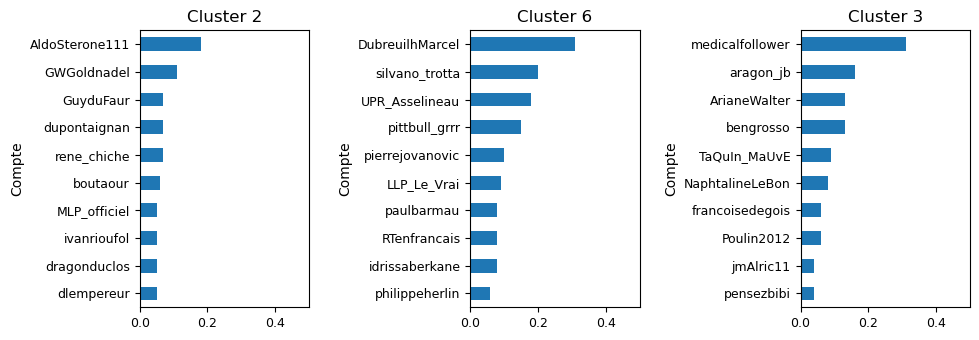

In [133]:
# On Visualise le résultat
fig, axs = plt.subplots(1,3,figsize=(10, 3.5))

ax1 =c2.set_index('Compte')['Centralité'].sort_values(ascending=True).plot(ax=axs[0], kind='barh', fontsize=9)
ax2 =c6.set_index('Compte')['Centralité'].sort_values(ascending=True).plot(ax=axs[1], kind='barh', fontsize=9)
ax3 =c3.set_index('Compte')['Centralité'].sort_values(ascending=True).plot(ax=axs[2], kind='barh', fontsize=9)

ax1.set_xlim(0,0.5)
ax2.set_xlim(0,0.5)
ax3.set_xlim(0,0.5)

ax1.title.set_text("Cluster 2")
ax2.title.set_text("Cluster 6")
ax3.title.set_text("Cluster 3")

plt.tight_layout()

Les deux autres clusters (n°1 et 4) sont plus difficiles à caractériser par les personnes qui les composent. En effet, ils sont centrés autour de personnalités peu connues et sans ancrage politique. Il sont en revanche plusieurs à avoir un profil médical ou scientifique (Corine Réverbel a un doctorat scientifique, Philipe Frogel est médecin, Didier Raoult est une personnalité de la médecine, Laissonslespre1 est un collectif de plusieurs centaines de médecins). On trouve également plusieurs personnes très impliquées sur les questions de société (Osterelisabeth est avocate, YvesPDB est un ancien homme politique Corse). Pour déterminer la spécificité de ces deux clusters il faudra avoir recours aux autres méthodes détaillées ci-dessous.

In [134]:
# Les figures centrales du cluster 1
c1 = centralite_betweeness(1, 10, connected_graph, cluster_7)
# Les figures centrales du cluster 4
c4 = centralite_betweeness(4,10, connected_graph, cluster_7)

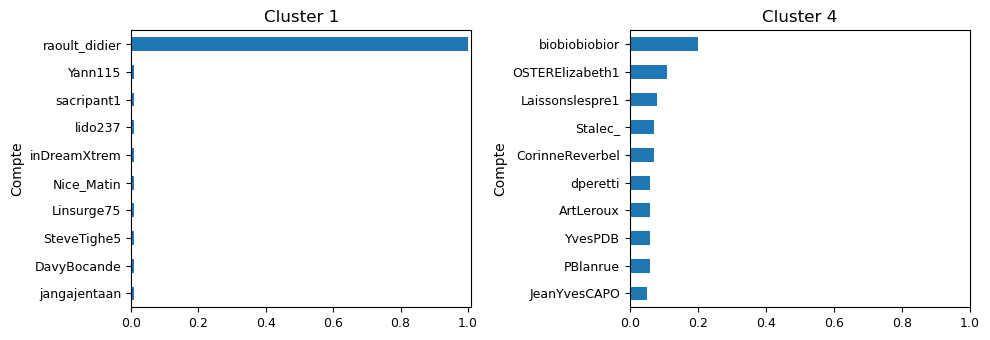

In [139]:
# On Visualise le résultat
fig, axs = plt.subplots(1,2,figsize=(10, 3.5))

ax1 =c1.set_index('Compte')['Centralité'].sort_values(ascending=True).plot(ax=axs[0], kind='barh', fontsize=9)
ax2 =c4.set_index('Compte')['Centralité'].sort_values(ascending=True).plot(ax=axs[1], kind='barh', fontsize=9)

ax1.set_xlim(0,1.01)
ax2.set_xlim(0,1)

ax1.title.set_text("Cluster 1")
ax2.title.set_text("Cluster 4")

plt.tight_layout()

**2. Caractériser les clusters par le contenu des tweets les plus retweetés**

Souhaitant compléter la caractérisation des clusters par des moyens plus qualitatifs. Nous avons choisis de lire les 1000 tweets les plus retweetés de notre corpus et de les classifier selon huit caractéristiques:

- Le tweet mentionne-t-il le pouvoir exécutif de la France où d'un autre pays (gouvernement, président, ministère, agence publique) ?
- Le Tweet mentionne-t-il des détails de l'étude (Source, méthode, auteur, analyses, résultats) ?
- Le Tweet est-il Défiant ou Confiant sur les conclusions de l'article ?
- Le Tweet mentionne-t-il des personnalité politiques ou des partis politiques (hors gouvernement)
- Le Tweet mentionne-t-il des entreprises ou industries privées pharmaceutiques ?
- Le tweet sous-entend-il ou affirme-t-il l'existence d'une situation de conflit d'intérêt (des auteurs, du Lancet ou entre les instances scientifiques et les institutions politiques) ?
- Le tweet discute-t-il du fonctionnement de la recherche (la recherche et ses aspects matériels et humains) ?
- Le tweet adopte-t-il un discours complotiste ? (Discours qui décrit un événement comme résultant pour l'essentiel de l'action planifiée et dissimulée d'un petit groupe, différent des acteurs apparents et marquée par une explication univoque et monocausale qui voit partout les signes de l'intervention et de la puissance de ce groupe secret)

Ces 1000 tweets comptabilisent 253 000 retweets soit 52% de l'ensemble du corpus et plus de 70% de tous les retweets. Il est légitime de penser que ces tweets qui ont acquis une grande visibilité l'ont été car ils ont été appréciés et considérés comme importants par la communauté. Déterminer quels types de tweets et plus massivement retweetés d'un cluster à l'autre permet de mettre en lumière les types de discours les plus appréciés par cluster.

In [15]:
# On charge la classification des 1000 les tweets les plus retweetés faits manuellement
path_data_1000rt = Path('./0.Input/Recodage_1000RT_CSV_V-TRIAGE.csv')
rt_1000 = pd.read_csv(path_data_1000rt, encoding='latin-1',header=0,sep=";")

# On constitue la liste des 1000 textes les plus RT. Les deux bases auront le même ordre:
bd_rt = Counter(data['text']).most_common(1000)
bd_rt_texte = []
for x in bd_rt:
    bd_rt_texte.append(x[0])

# ON FUSIONNE LES DEUX BASES
rt_1000["textes_propres"] = pd.Series(Counter(data['text']).most_common(1000))

**Quelques statistiques sur le corpus**

In [62]:
# Les auteurs ayant fait le plus de tweets retweetés

pd.DataFrame(Counter(rt_1000["Auteur"]).most_common(10), columns = ["Compte","Tweet dans le corpus"])

,Compte,Tweet dans le corpus
0,medicalfollower,38
1,CorinneReverbel,37
2,aragon_jb,32
3,biobiobiobior,31
4,OSTERElizabeth1,27
5,ArianeWalter,18
6,NaphtalineLeBon,16
7,dperetti,15
8,DubreuilhMarcel,14
9,dragonduclos,14


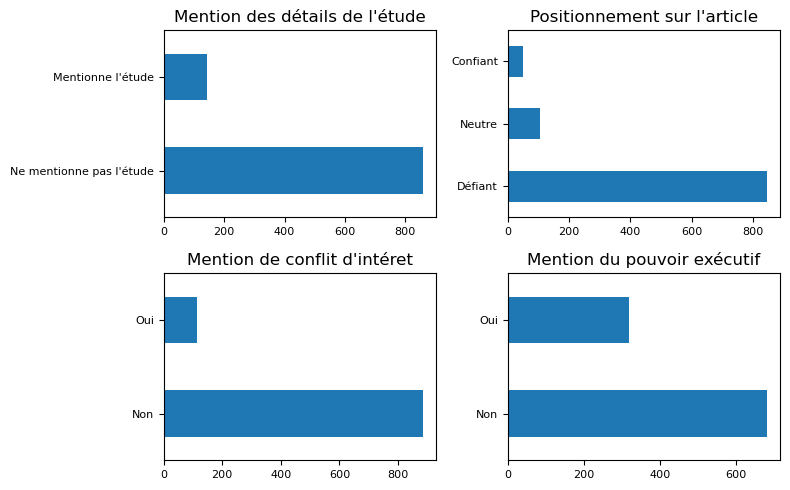

In [63]:
# Les caractéristiques de ces tweets

fig, axs = plt.subplots(2,2,figsize=(8, 5))

detail = pd.DataFrame(rt_1000["Details_etude"].value_counts())
detail.rename(index={0:"Ne mentionne pas l'étude", 1:"Mentionne l'étude"},inplace=True)

confiance = pd.DataFrame(rt_1000["Défiant_Confiant"].value_counts())
confiance.rename(index={"C":"Confiant", "D":"Défiant", "N":"Neutre"},inplace=True)

pouvoir = pd.DataFrame(rt_1000["Mention_Pouvoir"].value_counts())
pouvoir.rename(index={0:"Non", 1:"Oui"},inplace=True)

c_interet = pd.DataFrame(rt_1000["Mention_Conflit_interet"].value_counts())
c_interet.rename(index={0:"Non", 1:"Oui"},inplace=True)

ax1 = detail.plot(ax=axs[0,0], kind='barh', fontsize=8, legend=None)
ax2 = confiance.plot(ax=axs[0,1], kind='barh', fontsize=8, legend=None)
ax3 = pouvoir.plot(ax=axs[1,1], kind='barh', fontsize=8, legend=None)
ax4 = c_interet.plot(ax=axs[1,0], kind='barh', fontsize=8, legend=None)

ax1.title.set_text("Mention des détails de l'étude")
ax2.title.set_text("Positionnement sur l'article")
ax3.title.set_text("Mention du pouvoir exécutif")
ax4.title.set_text("Mention de conflit d'intéret")

plt.tight_layout()

**L'objectif est de propager l'information de ce recodage sur le réseau**

Nous créons un tableau avec les fréquences de retweet de chaque Cluster, c'est-à-dire la proportion de personne du Cluster ayant retweeté au moins un tweet sur les thèmes renseignés manuellement.

Pour être plus explicite, on regarde pour les 7 colonnes où nous avons fait des recodages (Défiant ou Confiant, Mentionne le pouvoir etc), la proportion de chaque cluster ayant retweeté au moins un de ces tweets. Par cette opération nous pouvons voir les attitudes et thèmes privilégiés des clusters sur l'article du Lancet.

In [60]:
# Aggrégation des résultats

personnes_list = []
clusters_list = []

personnes_uniques = []
liste_personnes_uniques = []

cluster_uniques = []

resultat_final = []

# On ouvre une boucle où on sélectionne le type d'infmation recodée
for c_name in ['Details_etude', 'Défiant_Confiant','Mention_Pouvoir', 'Mention_acteurs_pharma',
       'Mention_Personnalite_politique', 'Mention_Conflit_interet','Mention_fonctionnement_recherche', 'Discours_complotiste']:
    
    # Ici on sélectionne le critère qui servira de référence. Nous faisons le choix de compter les RT défiants ET les RT ayant une des caractéristiques recodées (donc égale à 1)
    if c_name == 'Défiant_Confiant':
        critere = 'D'
    else:
        critere = 1
    
    # On sélectionne tous les comptes ayant RT un tweet correspondant au critère recherché
    for x in range(0, len(rt_1000)):
        if rt_1000[c_name].iloc[x] == critere:
            personnes_list = personnes_list + data[data.text == rt_1000["textes_propres"].iloc[x][0]  ]['from_user_name'].values.tolist()
            clusters_list = clusters_list + data[data.text == rt_1000["textes_propres"].iloc[x][0]  ]['Cluster'].values.tolist()
    
    # On supprime tous les doublons pour ne garder que les comptes uniques
    for x in range(0,len(personnes_list)):
        if personnes_list[x] not in personnes_uniques:
            personnes_uniques.append(personnes_list[x])
            cluster_uniques.append(clusters_list[x])
    
    personnes_list = []
    clusters_list = []
    
    # On compte le nombre de personne de chaque culster qu'on ajoute dans une liste temporaire
    sublist = [Counter(cluster_uniques)[0], Counter(cluster_uniques)[1], Counter(cluster_uniques)[2],
              Counter(cluster_uniques)[3], Counter(cluster_uniques)[4],Counter(cluster_uniques)[5],
               Counter(cluster_uniques)[6]]
        
    personnes_uniques = []
    cluster_uniques = []
    
    # On ajoute la liste temporaire dans une liste qui stock tous les résultats
    resultat_final.append(sublist)

In [68]:
#Nombre total de membre de chaque Cluster. Tableur qui sera utilisé pour faire des calculs de fréquence
effectif_total_cluster = [ data[data.Cluster == 0]['from_user_name'].nunique(),
                          data[data.Cluster == 1]['from_user_name'].nunique(), 
                          data[data.Cluster == 2]['from_user_name'].nunique(),
                          data[data.Cluster == 3]['from_user_name'].nunique(),
                          data[data.Cluster == 4]['from_user_name'].nunique(),
                          data[data.Cluster == 5]['from_user_name'].nunique(),
                          data[data.Cluster == 6]['from_user_name'].nunique()     ]

# On créé le tableau en divisant les effectifs ayant retweeté chacun des tweets par le nombre de personnes de chaque Cluster
tableur_freq_aggrege = []

# On réalise la division pour avoir la fréquence pour chaque cluster et pour chaque ligne
for ligne in resultat_final:
    ligne =[ round(i / j ,2) for i, j in zip(ligne, effectif_total_cluster)]
    tableur_freq_aggrege.append(ligne)

# On ajoute le tout dans un dataframe
df_tableur_freq_aggrege = pd.DataFrame({'Caracteristiques du Tweet':["Discute des détails de l'étude", "Est Défiant sur l'article",'Mentionne le Pouvoir excécutif et affilié', 'Mentionne des acteurs pharmacieutiques privés',
       'Mentionne une personnalité politique', "Mentionne un conflit d'intéret",'Discute du fonctionnement de la recherche', 'Tiens un discours Conspirationiste'],
                        'Cluster 0': None,
                       'Cluster 1': None,
                       'Cluster 2': None,
                       'Cluster 3': None,
                       'Cluster 4': None,
                       'Cluster 5': None,
                       'Cluster 6': None})

# On ajoute les fréquences
for x in range(0,len(resultat_final)):
    df_tableur_freq_aggrege['Cluster 0'].iloc[x] = str(int(round(tableur_freq_aggrege[x][0]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 1'].iloc[x] = str(int(round(tableur_freq_aggrege[x][1]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 2'].iloc[x] = str(int(round(tableur_freq_aggrege[x][2]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 3'].iloc[x] = str(int(round(tableur_freq_aggrege[x][3]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 4'].iloc[x] = str(int(round(tableur_freq_aggrege[x][4]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 5'].iloc[x] = str(int(round(tableur_freq_aggrege[x][5]*100,1))) + "%"
    df_tableur_freq_aggrege['Cluster 6'].iloc[x] = str(int(round(tableur_freq_aggrege[x][6]*100,1))) + "%"

In [67]:
# On observe les résultats en fonction du nombre total de personnes de chaque cluster:
df_tableur_freq_aggrege

,Caracteristiques,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,Discute des détails de l'étude,25%,71%,44%,41%,39%,14%,43%
1,Est Défiant sur l'article,29%,96%,89%,88%,74%,39%,82%
2,Mentionne le Pouvoir excécutif et affilié,18%,37%,65%,64%,46%,20%,48%
3,Mentionne des acteurs pharmacieutiques privés,2%,8%,34%,29%,26%,4%,26%
4,Mentionne une personnalité politique,17%,6%,34%,13%,20%,3%,29%
5,Mentionne un conflit d'intéret,11%,11%,46%,39%,33%,10%,38%
6,Discute du fonctionnement de la recherche,7%,20%,30%,27%,29%,5%,24%
7,Tiens un discours Conspirationiste,3%,3%,19%,18%,14%,1%,13%


*Lecture*: 
- *89% des membres du cluster 2 ont retweeté un Tweet "défiant" contre 29% pour le Cluster 9*
- *39% des membres du cluster 3 (cluster de gauche) ont retweeté un tweet parlant de "conflit d'interêts" contre 11% pour le cluster 1*

Quand on se penche sur les différences entre partisans et adversaires de l'article du Lancet, on constate des écarts importants sur tous les sujets recodés manuellement. Globalement, les opposants de l'article semblent à la fois plus intrigués par les détails de l'étude mais également sont beaucoup plus nombreux à diffuser des tweets tenant un discours dépassant la controverse et intégrant des aspects de gouvernance, de structuration du secteur de la santé et du fonctionnement de la recherche jugé trop exposé aux conflits d'intérêts, manquant de transparence ou n'étant pas dans l'intérêt de la population. 

Un point particulièrement intéressant est la plus faible proportion des partisans de l'article à retweeter des tweets parlant des détails de l'étude alors que ses membres mettent en avant de se concentrer sur les arguments.  Cela peut aussi provenir d'un effet de filtrage de constitution du corpus. 

Il existe des différences entre les différents clusters composant la "galaxie" critique l'article du Lancet. Nous avions pu observer que le cluster 2 avait des connexions fortes avec l'extrême droite française, le cluster 3 des connexions relativement lâches avec la gauche et le cluster 6 semblait marqué par la présence de figures promouvant des faits et des théories alternatives souvent très inquiets de possible manipulations de grandes ampleurs. Il restait néanmoins difficile de déterminer les spécificités des clusters 1 et 4. Il apparaît ici que le cluster "Raouliste" se distingue des autres par:
- Des retweets beaucoup plus ciblés sur le contenu de l'étude.
- Des retweets moins nombreux sur des sujets de débats plus larges comme le gouvernement, les acteurs pharmaceutiques ou la problématique des conflits d'intérêts.
- Une attitude plus académique et moins portée sur des théories très alternatives
Le cluster 4 dont l'orientation reste relativement difficile à cerner semble in fine plus proche des clusters 7,10 et 12 qui sont plus "politisés" et élargissent le débat a d'autres aspects que la seule analyse de l'article. 

**3. Caractériser les clusters par liens URLs partagés**

Pour continuer la caractérisation de chaque cluster nous observerons les liens URLs les plus partagés et les liens les plus spécifiques.

Les deux groupes opposés sont caractérisés par l'utilisation importante de liens redirigeant vers des médias mainstreams (lemonde, libération, bfmtv, franececulture). Ainsi, malgré leur opposition, ils ont globalement les mêmes sources et les mêmes manières de s'informer. Cela va entre autres à rebours des stéréotypes concernant les partisans de la chloroquine souvent caricaturés comme utilisant des sources douteuses, non scientifiques ou peu traçables. Les deux groupes se distinguent néanmoins sur certains points

Les Partisans de l'article se caractérisent par:
- Une utilisation plus forte de certains sites spécialisés scientifiques (lancet, scienceEtVie, marlin-prod.literatumonline.com) ou de "debunkage" (Conspiracy Watch).
- Une plus grande utilisation des sites d'information Français.

Les Opposants de l'article ont: 
- Un référencement au site du Lancet beaucoup plus faible.
- Plusieurs sources médiatiques alternatives dont on peut penser qu'elles sont utilisées pour comparer ou concurrencer les médias français classiques jugés peu fiables. On y trouve aussi bien des médias étrangers (Espagnol, Ivoirien, Indien, États-Uniens) et des sources alternatives non médiatiques (Upr, Courrier des stratèges, jdmichel.blogspot).

In [143]:
# Code pour extraire les liens URLs et calculer les fréquences
for cluster in [0,1]:
    
    # On extrait les urls et les domaines
    url_domaine = list(pd.Series([(urlparse(str(j)).netloc) for i in list(data[data.Cluster_2class == cluster]["links"].dropna().apply(lambda x : x.lower().split("|"))) for j in i]))
        
    url_domaine = [value for value in url_domaine if value != "twitter.com"]
    url_domaine = list(map(lambda x: x.replace('amp-theguardian-com.cdn.ampproject.org', 'www.theguardian.com'), url_domaine))
    
    df_liens = pd.DataFrame(Counter(url_domaine).most_common(15), columns=['Site', 'Nombre_partage'])
       
    # On calcul les pourcentages
    pourcentage = []
    for index, row in df_liens.iterrows():
        pourcentage.append(round( row['Nombre_partage'] / len(url_domaine) ,3) )
        
    # On exporte nos datframe finaux pour les cluster pro Article (1) et anti article (71)
    if cluster == 0:
        df_liens_0 = pd.DataFrame({'Site':df_liens['Site'], 'Nb':df_liens['Nombre_partage'], '%':pourcentage })
    if cluster == 1:
        df_liens_1 = pd.DataFrame({'Site':df_liens['Site'], 'Nb':df_liens['Nombre_partage'], '%':pourcentage })

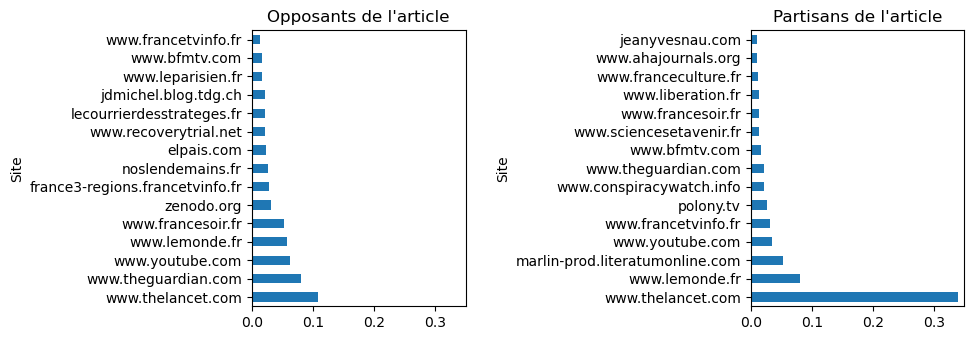

In [144]:
# On visualise le résultat
fig, axs = plt.subplots(1,2,figsize=(10, 3.5))

ax1 =df_liens_0.set_index('Site')['%'].plot(ax=axs[0], kind='barh', fontsize=10)
ax2 =df_liens_1.set_index('Site')['%'].plot(ax=axs[1], kind='barh', fontsize=10)

ax1.set_xlim(0,0.35)
ax2.set_xlim(0,0.35)

ax1.title.set_text("Opposants de l'article")
ax2.title.set_text("Partisans de l'article")

plt.tight_layout()

### Synthèse de la caractérisation des clusters

Nous avons donc, à l'exception des médias, deux grands groupes: 

**1. Un cluster défendant l'artice** minoritaire. Il compte comme leaders des scientifiques ou médecins ou des personnes inquiètes de la diffusion de discours alternatifs et de théories parfois anti-sciences et qui développent un discours de vulgarisation ou de "debunkage". On ne trouve pas de discours discutant des institutions, gouvernement ou de l'organisation du secteur de la santé ou de la recherche scientifique (pas de mention de laboratoire par exemple). Autre point intéressant, les membres de ce cluster sont moins nombreux à avoir retweeté des tweets parlant des détails de l'étude ce qui pourrait suggérer une plus grande confiance dans le Lancet et autres "institutions" scientifiques. 

**3. Un cluster opposé à l'article** largement majoritaire mais fragmenté. Ce groupe est fédéré par Didier Raoult dont le rôle central est ici visible. Il est possible que la relative neutralité politique ou idéologique des contenus des tweets de Didier Raoult permettent cette coagulation, chaque sous cluster pouvant utiliser sa légitimité et ses arguments scientifiques pour l'intégrer à son propre discours. Cette communauté s'est largement mobilisée et est à l'origine du "#LanceGate". 

En l'état actuel de l'analyse nous pouvons identifier ***deux blocs*** relativement distincts dans cette galaxie d'opposant:
- Un groupe que l'on qualifiera de "**Critique systémique**", caractérisé par un intérêt allant au delà de la controverse scientifique qui englobe des décisions prises par le pouvoir exécutif, la structuration du monde de la recherche et du monde médical et les liens perçus comme troubles entre groupes privés, gouvernement et recherche. Cela se confirme avec les hashtags plutôt signifiant de ce groupe : "#Ethique", "#Gilead" ou "#Bigpharma". A rebours des stéréotypes diabolisant les partisans de la Chloroquine, les discussions les plus diffusées restent assez "sensées" et construites, mentionnant peu de théorie très alternative ou remettant en cause la "Science" comme méthode pour comprendre le monde. Ce groupe intègre:
    - Le cluster avec un ancrage à l'extrême droite (cluster 2)
    - Le cluster avec un ancrage à gauche ou à l'extrême gauche (Le cluster 4).
    - Le cluster des partisans des théories alternatives (Cluster 6)
    - Le cluster n° 4 sans affiliation partisane claire
    Précisons enfin que malgré un ancrage visible (droite, gauche, sphère conspirationnistes) les discours sont relativement similaires malgré la présence de "leaders" très différents.
    
- L'autre groupe est constitué par le cluster centré autour de la personne de Didier Raoult, les **Critiques spécifiques**, qui semble lui plus centré sur la controverse scientifique, avance des arguments sur le contenu de l'étude, la méthode ou les conclusions et semble peu impliqué dans des débats plus sociétaux ou politiques. 

**4. Des communauté a l'engagement variable**

Nous souhaitons pour terminer cette partie identifier les comptes ayant fait le plus de tweets (les comptes les plus actifs) pour mesurer si certaintes communautés sont plus actives et plus engagés dans la controverse que d'autres. Pour cela nous compterons le nombre de tweets pendant les trois semaines de la polémique. 

In [85]:
# Préparation des données: 

# Nous créons un dictionnaire où figure les comptes et leur cluster d'appartenance
liste_nodes = []
cluster = []
nb = -1
for groupe in cluster_7:
    nb = nb + 1
    for node in groupe:
        liste_nodes.append(node)
        cluster.append(nb)

dic_muti = pd.DataFrame({'Node': liste_nodes, 'Cluster': cluster,'retweeted_cluster_name':cluster }).set_index("Node")
dic_node_cluster = pd.DataFrame(dic_muti["Cluster"])

# On créé un DF contenant le nombre de tweets fait par compte
nb_tweets = pd.DataFrame(Counter(data["from_user_name"]).most_common(data["from_user_name"].nunique()), columns=['Nom', 'Nombre_tweets']).set_index("Nom")

# On fait une jointure pour obtenir un DF contenant le cluster d'origine ET le nombre de tweets fait par chaque compte
Node_nbtweets = dic_node_cluster.join(nb_tweets, on = "Node") 

In [122]:
# On créer un tableau pour identifier les comptes ayant fait plus de 100 tweets et voir a quels clusters ils appartiennent
tweet100 = pyshs.tri_a_plat(Node_nbtweets[Node_nbtweets.Nombre_tweets > 100],"Cluster")
tweet100.index.names = ['Cluster']
tweet100 = tweet100.rename(columns={'Pourcentage (%)': '% avec +100 tweets', 'Effectif':'Nb de comptes'})

In [123]:
# On extrait la proportion normale des clusters pour comparer
prop_cluster = pyshs.tri_a_plat(Node_nbtweets,"Cluster")
prop_cluster = prop_cluster.rename(columns={'Pourcentage (%)': '% du Cluster'})
prop_cluster.index.names = ['Cluster']
prop_cluster = pd.DataFrame(prop_cluster["% du Cluster"])

#On joit les 2 tableaux
merge = tweet100.join(prop_cluster, on = "Cluster") 

In [124]:
# On visualise le tableau
merge

,Nb de comptes,% avec +100 tweets,% du Cluster
Cluster,,,
0,60.0,10.1,23.9
1,2.0,0.3,21.2
2,161.0,27.1,14.1
3,68.0,11.4,13.9
4,275.0,46.2,9.6
5,3.0,0.5,7.7
6,16.0,2.7,4.4
7,10.0,1.7,5.2
Total,595.0,100.0,100.0


Le **cluster 4** et le **cluster 2** sont particulièrement actifs car ils représentent 73% des comptes ayant fait plus de 100 tweets alors qu'ils ne constituent que 23% des comptes. Le Cluster 4 se distingue particulièrement, surtout chez les comptes les plus actifs puisque 13 des 15 comptes les plus engagés en font partie. Plusieurs dizaines de comptes de ces deux communautés ont réalisé un militantisme très actif pour faire connaître et prévaloir un point de vue critique sur l'article et possiblement sur l'ensemble de la politique sanitaire du gouvernement.

In [125]:
# Le Cluster des 15 comptes ayant fait le plus de tweets
Node_nbtweets.sort_values("Nombre_tweets", ascending = False)[0:15]

,Cluster,Nombre_tweets
Node,,
VotezPoisson,4,916.0
JaiRaison,4,913.0
julien0686,4,871.0
aragon_jb,3,825.0
EzzedineMarie,4,813.0
FlaurentNeuhaus,4,810.0
Mahon69072212,4,766.0
Clairemanon10,4,741.0
jfpleimelding,4,737.0


**Une controverse augmentant l'audience de figures critiques de la gestion publique**

En regardant l'évolution du nombre de followers de tous les comptes de notre corpus, on constate qu'en termes de gain absolu de followers, les médias et Didier Raoult sont ceux ayant le plus augmenté en valeurs absolues leur audience. Cela est relativement logique car ils bénéficiaient d'une audience et d'une exposition préalable importante. La performance de Didier Raoult (+54 000 followers) reste notable car il devance plusieurs comptes bien plus populaires ce qui confirme la cristallisation de l'attention sur ses positions.

In [187]:
# On extrait les 1000 comptes les plus retweetés
comptes = pd.DataFrame(Counter(data["retweeted_user_name"]).most_common(1000), columns = ["Compte", "nb"] )
comptes = list(comptes[1:-1]["Compte"])

In [188]:
# On extrait pour les 1000 plus gros comptes le nombre de follower au DEBUT et a la FIN
followers_debut = []
followers_fin = []
diff = []
compte = []
dif_ratio = []
cluster2 = []
cluster7 = []

# On créé une boucle sur les comptes
for auteur in comptes:
    compte.append(auteur)
    
    # On vérifie qu'ils aient fait au moins 2 tweets permettant de mesurer l'évolution.
    # Si le compte a au moins deux tweets
    if len(data[data.from_user_name == auteur]) >= 2:
        
        # On extrait le nombre de follower au moment de son premier tweet et de on dernier tweet
        res = list(data[data.from_user_name == auteur]["from_user_followercount"][::len(data[data.from_user_name == auteur]["from_user_followercount"])-1])
        followers_debut.append(res[0])
        followers_fin.append(res[1])
        diff.append(res[1]-res[0])
        dif_ratio.append( round((  (res[1]+1) - (res[0]+1))/(res[0]+1),2) )
    
    # Si le compte n'a fait qu'un seul tweet    
    else:
        #On ne calcul pas la progression et on garde le nombre de followers au moment du seul tweet
        followers_debut.append(data[data.from_user_name == auteur]["from_user_followercount"].values[0])
        followers_fin.append(data[data.from_user_name == auteur]["from_user_followercount"].values[0])
        diff.append(0)
        dif_ratio.append(0)
    
    cluster2.append(data[data.from_user_name == auteur]["Cluster_2class"].values[0])
    cluster7.append(data[data.from_user_name == auteur]["Cluster"].values[0])

df = pd.DataFrame({"Nom": compte, "followers_debut":followers_debut, "followers_fin":followers_fin, "diff":diff, "diff_%":dif_ratio, "cluster_2":cluster2,"cluster_7":cluster7 }) 

In [189]:
# On rajoute un code couleur (en  fonction du cluster d'appartenance) pour les graphiques ci-dessous

df["Couleurs_7"] = df["cluster_7"]
df["Couleurs_2"] = df["cluster_2"]

df['Couleurs_7'] = df['Couleurs_7'].replace([0.0], 'forestgreen')
df['Couleurs_7'] = df['Couleurs_7'].replace([1.0], 'darkgoldenrod')
df['Couleurs_7'] = df['Couleurs_7'].replace([2.0], 'saddlebrown')
df['Couleurs_7'] = df['Couleurs_7'].replace([3.0], 'crimson')
df['Couleurs_7'] = df['Couleurs_7'].replace([4.0], 'darkorange')
df['Couleurs_7'] = df['Couleurs_7'].replace([5.0], 'darkcyan')
df['Couleurs_7'] = df['Couleurs_7'].replace([6.0], 'orchid')
df['Couleurs_7'] = df['Couleurs_7'].replace([7.0], 'grey')
df['Couleurs_7'] = df['Couleurs_7'].replace([np.nan], 'grey')

df['Couleurs_2'] = df['Couleurs_2'].replace([0.0], 'red')
df['Couleurs_2'] = df['Couleurs_2'].replace([1.0], 'green')
df['Couleurs_2'] = df['Couleurs_2'].replace([np.nan], 'grey')

df_1 = df.sort_values('diff', ascending=False)[0:30]

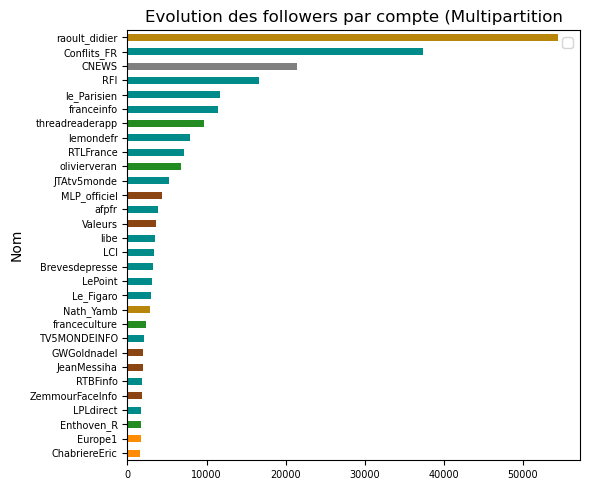

In [215]:
# On Visualise le résultat
fig, ax = plt.subplots(figsize=(6, 5))

ax = df_1.sort_values('diff', ascending=True).set_index('Nom')['diff'].plot(kind='barh', fontsize=7, color = df_1.sort_values('diff', ascending=True)['Couleurs_7'])

ax.title.set_text("Evolution des followers par compte (Multipartition)")

plt.tight_layout()

**Evolution du nombre de followers en terme de %**

On souhaite regarder les gains relatifs du nombre de followers pour mettre en lumière les plus fortes variations. Cela est judiceux car beaucoup de petits comptes ont connu de fortes progressions masquées par les comptes les plus importants.
Rapporté à l'audience initiale  de chaque compte, on constate que ce sont surtout des comptes de particuliers et plus spécifiquement du Cluster 4 qui ont le plus progressé. Par exemple Biobiobor passe de 713 a 1328 followers ou "medicalfollower" de 1800 à 2800.

In [217]:
# On exclut les petits comptes dont les variations sont parfois extrême
df_2 = df[df.followers_debut >300].sort_values('diff_%', ascending=False)[0:30]

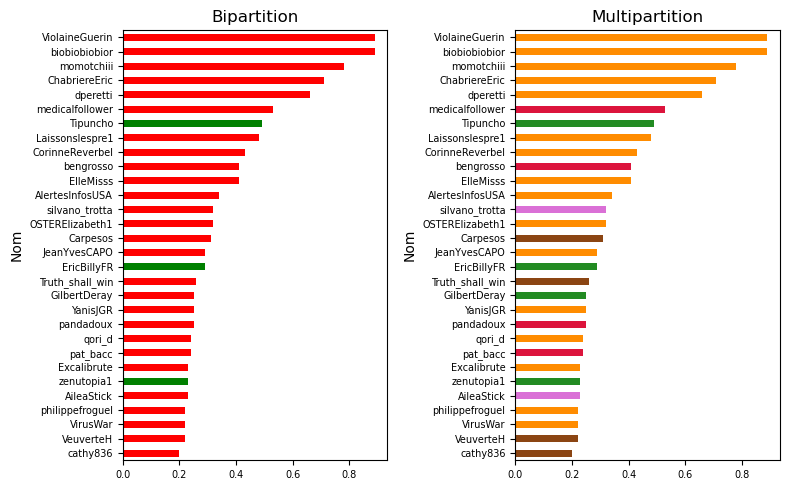

In [219]:
# On Visualise le résultat
fig, axs = plt.subplots(1,2,figsize=(8, 5))

ax1 =df_2.sort_values('diff_%', ascending=True).set_index('Nom')['diff_%'].plot(ax=axs[0],kind='barh', fontsize=7, color = df_2.sort_values('diff_%', ascending=True)['Couleurs_2'])
ax2 =df_2.sort_values('diff_%', ascending=True).set_index('Nom')['diff_%'].plot(ax=axs[1],kind='barh', fontsize=7, color = df_2.sort_values('diff_%', ascending=True)['Couleurs_7'])

ax1.title.set_text("Bipartition")
ax2.title.set_text("Multipartition")

plt.tight_layout()

<a id='5'></a>

## 5. Un débat à sens unique

Nous l'avons vu plus haut, les opposants sont in fine beaucoup plus nombreux que les partisans de l'article. Il est possible que cet avantage se soit concrétisé progressivement, au cours de la polémique. Cependant l'analyse des données sur le plan temporel montre qu'en réalité il ne semble jamais y avoir eu de controverse, un camp devenant dominant très rapidement et ce même avant les premières inquiétudes venant des sphères légitime (lettre ouverte, Lancet, autorités sanitaires etc). 

Les premiers retweets massifs contre l'étude le 23,24 et 25 mai s'attaquent d'abord à des présomptions de conflit d'intérêt sans s'attaquer aux résultats proprement dits. C'est le 26 que Didier Raoult fais les premiers commentaires sur les données elles-mêmes et qu'il surclasse immédiatement tous les autres comptes.

On peut donc s'interroger sur l'utilisation de la notion de controverse. Il semble qu'il soit plus opportun de parler d'une mobilisation publique vers un objet scientifique.

**Dynamique des hashtags**:

In [74]:
originaux = ['chloroquine', 'hydroxychloroquine', 'raoult', 'covid19', 'veran','covidー19', 'véran', 'coronavirus',
             'hydroxycloroquine','hydroxychroloquine', 'covid_19', 'didierraoult', 'olivierveran',
             'hydroxychloriquine', 'covid', 'covid__19', 'hcq', 'vèran','chloraquinine', 'hydoxychloroquine',
             'didier_raoult','thelancetgate', 'raoult_didier', 'covid?19', 'thelancet']

remplacement = ['Hydroxychloroquine ', 'Hydroxychloroquine ', 'd_raoult ','Covid-19', 'Veran', 'Covid-19', 'Veran',
                'Covid-19', 'Hydroxychloroquine ', 'Hydroxychloroquine ', 'Covid-19','d_raoult ', 'Veran',
                'Hydroxychloroquine ', 'Covid-19','Covid-19', 'Hydroxychloroquine ', 'Veran', 'Hydroxychloroquine ',
                'Hydroxychloroquine ', 'd_raoult ', 'lancetgate', 'd_raoult ','Covid-19', 'lancet']

correction_hashtags = pd.DataFrame({'Originaux': originaux, 'Remplacement': remplacement})

In [75]:
dates_1 = list(data[data.hashtags.notnull()]["date"])
hashtag_total = list(pd.Series(data["hashtags"].dropna().apply(lambda x : x.lower().split("|"))))

hashtag = []
dates = []
nb = -1
for sublist in hashtag_total:
    nb = nb +1
    for item in sublist:
        hashtag.append(item)
        dates.append(dates_1[nb])

# On harmonise l'orthographe
for index, h_bon in correction_hashtags.iterrows():
    hashtag = [word if word != h_bon['Originaux'] else h_bon['Remplacement'] for word in hashtag]
hashtag = list(map(lambda x: x.replace('covidー19', 'Covid-19'), hashtag))

df_hashtag = pd.DataFrame({'hashtag': hashtag, 'dates': dates})

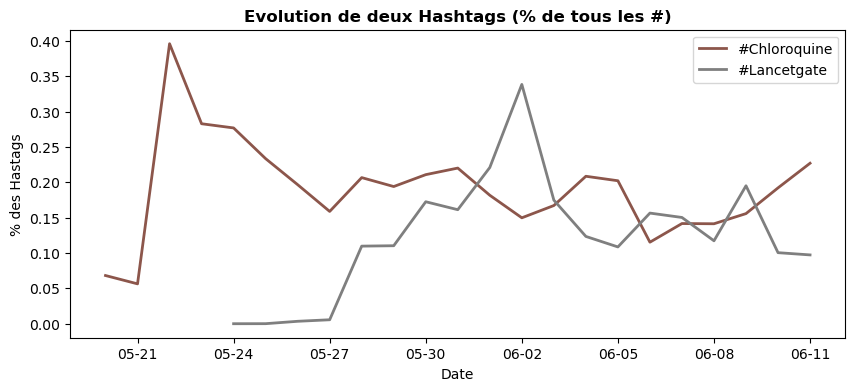

In [76]:
# Graphique d'évolution
h_hcq = df_hashtag[df_hashtag.hashtag == "Hydroxychloroquine "]['dates'].value_counts().sort_index() / df_hashtag['dates'].value_counts().sort_index()
h_lancetgate = df_hashtag[df_hashtag.hashtag == "lancetgate"]['dates'].value_counts().sort_index()/ df_hashtag['dates'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(h_hcq, axes=ax, linewidth=2, color='C5',label="#Chloroquine")
plt.plot(h_lancetgate, axes=ax, linewidth=2, color='C7',label="#Lancetgate")

half_year_locator = mdates.DayLocator(interval=2) #♪Interval de dates
ax.xaxis.set_major_locator(half_year_locator) #♪Interval de dates

dfmt = DateFormatter("%m-%d") # Formatage de la date: sans l'année
ax.xaxis.set_major_formatter(dfmt) # Formatage de la date: sans l'année

plt.title("Evolution de deux Hashtags (% de tous les #)", loc='Center', fontsize=12, fontweight="bold", color='black')
ax.set_xlabel("Date")
ax.set_ylabel("% des Hastags") 
ax.legend(loc="upper right")

**Evolution temporelle du nombre de tweets faits par les clusters**

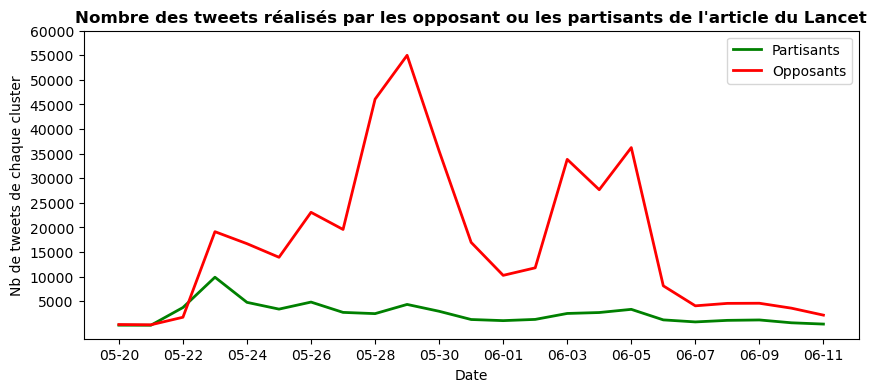

In [63]:
# Pro et Anti

# Sélection des Clusters
c_pro = data[data.Cluster_2class == 1].groupby(\
              pd.Grouper(key='created_at', freq='D')).size()

c_anti = data[data.Cluster_2class == 0].groupby(\
              pd.Grouper(key='created_at', freq='D')).size()

# Mise en forme
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(c_pro, axes=ax, linewidth=2, color='green',label="Partisants")
plt.plot(c_anti, axes=ax, linewidth=2, color='red',label="Opposants")

plt.yticks([5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000])

half_year_locator = mdates.DayLocator(interval=2) #Interval de dates
ax.xaxis.set_major_locator(half_year_locator) #Interval de dates
dfmt = DateFormatter("%m-%d") # Formatage de la date: sans l'année
ax.xaxis.set_major_formatter(dfmt) # Formatage de la date: sans l'année

plt.title("Nombre des tweets réalisés par les opposant ou les partisants de l'article du Lancet", loc='Center', fontsize=12, fontweight="bold", color='black')
ax.set_xlabel("Date")
ax.set_ylabel("Nb de tweets de chaque cluster") 
ax.legend(loc="upper right")

## ANNEXES

**Visualisation de 3 tweets et Clusterisation complète**

In [221]:
import networkx as nx
import matplotlib.pyplot as plt

In [222]:
fichier = "C:/Users/Simon/Dropbox/Mon PC (LAPTOP-E60PD4FT)/Desktop/Stage-MediaLab/LancetGate/1.Visualisation_GEPHI/3.Exports_Final/Graph_Multipartition-Gephi.gexf.graphml"
G = nx.read_graphml(fichier)

In [223]:
def code_color(x):
    if x:
        return "r"
    else:
        return "lightgrey"

def alpha_value(x):
    if x:
        return 1
    else:
        return 0.05

In [224]:
tweet_1 = list(data[data.retweeted_id == 1265914255234289664]["from_user_name"].values)
code_1 = {i:i in tweet_1 for i in G.nodes}
nx.set_node_attributes(G,code_1,name="Tweet")
color_1 = nx.get_node_attributes(G, 'Tweet')
alpha_1 = [alpha_value(color_1[i]) for i in color_1]
color_1 = [code_color(color_1[i]) for i in color_1]

tweet_2 = list(data[data.retweeted_id == 1264145851955458048]["from_user_name"].values)
code_2 = {i:i in tweet_2 for i in G.nodes}
nx.set_node_attributes(G,code_2,name="Tweet")
color_2 = nx.get_node_attributes(G, 'Tweet')
alpha_2 = [alpha_value(color_2[i]) for i in color_2]
color_2 = [code_color(color_2[i]) for i in color_2]

tweet_3 = list(data[data.retweeted_id == 1268634745828753411]["from_user_name"].values)
code_3 = {i:i in tweet_3 for i in G.nodes}
nx.set_node_attributes(G,code_3,name="Tweet")
color_3 = nx.get_node_attributes(G, 'Tweet')
alpha_3 = [alpha_value(color_3[i]) for i in color_3]
color_3 = [code_color(color_3[i]) for i in color_3]

In [225]:
pos_x = nx.get_node_attributes(G, 'x')
pos_y = nx.get_node_attributes(G, 'y')
pos_xy = {i:[pos_x[i],pos_y[i]] for i in pos_x}
ns = nx.get_node_attributes(G, 'size')

node_size = [ns[i]/8 for i in G.nodes]

In [13]:
top_auteur = ['raoult_didier','medicalfollower' ,'biobiobiobior' ,'GilbertDeray', 'CNEWS', 'lemondefr', 'olivierveran']

In [226]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('C:/Users/Simon/Dropbox/Mon PC (LAPTOP-E60PD4FT)/Desktop/Stage-MediaLab/LancetGate/1.Visualisation_GEPHI/3.Exports_Final/Export_01_Multipartition_Reseau_Finalisation.png')

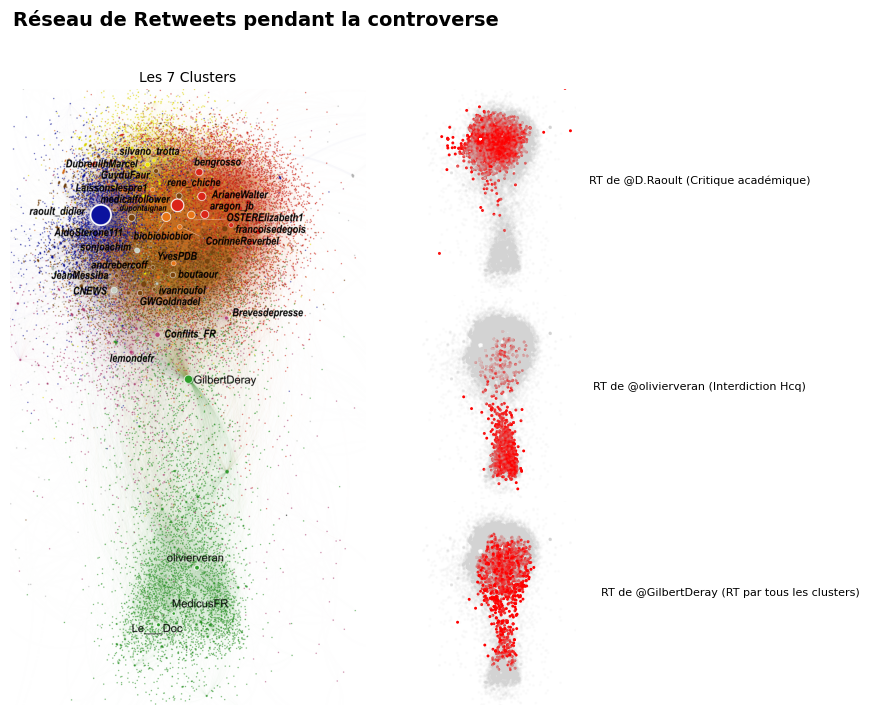

In [227]:
fig = plt.figure(figsize=(8,8))
axs = fig.subplot_mosaic([['Left', 'Top'],
                          ['Left', 'Middle'],
                          ['Left', 'Bottom']],
                          gridspec_kw={'width_ratios':[3,1]})

fig.suptitle('Réseau de Retweets pendant la controverse',fontsize=14, fontweight="bold")
axs['Left'].set_title('Les 7 Clusters', fontsize=10,)
axs['Top'].set_title('RT de @D.Raoult (Critique académique)', fontsize=8, x=1.8, y=0.5)
axs['Middle'].set_title('RT de @olivierveran (Interdiction Hcq)', fontsize=8, x=1.8, y=0.5)
axs['Bottom'].set_title('RT de @GilbertDeray (RT par tous les clusters)', fontsize=8, x=2, y=0.5)

axs['Left'].imshow(img)
nx.draw_networkx_nodes(G,pos_xy, node_size=node_size, alpha=alpha_1, node_color=color_1, ax=axs['Top'])
nx.draw_networkx_nodes(G,pos_xy, node_size=node_size, alpha=alpha_2, node_color=color_2, ax=axs['Middle'])
nx.draw_networkx_nodes(G,pos_xy, node_size=node_size, alpha=alpha_3, node_color=color_3, ax=axs['Bottom'])

axs['Top'].set_xlim(-5000, 5000)
axs['Top'].set_ylim(-8000, 4000)
axs['Top'].margins(x=-0.05, y=-0.05)

axs['Middle'].set_xlim(-5000, 5000)
axs['Middle'].set_ylim(-8000, 4000)
axs['Middle'].margins(x=-0.05, y=-0.05)

axs['Bottom'].set_xlim(-5000, 5000)
axs['Bottom'].set_ylim(-8000, 4000)
axs['Bottom'].margins(x=-0.05, y=-0.05)

axs['Left'].margins(x=-0.01, y=-0.01)

axs['Left'].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

axs['Left'].set_frame_on(False)
axs['Top'].set_frame_on(False)
axs['Middle'].set_frame_on(False)
axs['Bottom'].set_frame_on(False)

plt.subplots_adjust(wspace=0.01, hspace=0.01)

**Tweet de @D.Raoult**: 
"RT @raoult_didier: Les autorités australiennes interrogées par le Guardian Australia s'interrogent sur les fortes discordances entre les données de l'article de Mehra et al dans le Lancet et leurs données nationales. Elles ne comprennent pas quels hôpitaux ont partagé leurs données patient. (1/2)"

**Tweet de Olivier Veran**:
RT @olivierveran: Suite à la publication dans @TheLancet d'une étude alertant sur l'inefficacité et les risques de certains traitements du #COVIDー19 dont l'hydroxychloroquine, j'ai saisi le @HCSP_fr pour qu'il l'analyse et me propose sous 48h une révision des règles dérogatoires de prescription.

**Tweet de @GilberDeray**:
'RT @GilbertDeray: L’article du Lancet est retiré ce qui était attendu. La fraude est probable, une enquête est en cours. C’est un immense scandale très préjudiciable à la communauté scientifique.'

**Export de tweets**

In [136]:
import requests
class Tweet(object):
    """
    Object to visualize a specific tweet
    """
    def __init__(self, s):
        """
        s : id of a tweet
        """
        s = f"https://twitter.com/OReillyMedia/status/{s}"
        api = 'https://publish.twitter.com/oembed?url={}'.format(s)
        response = requests.get(api)
        self.text = response.json()["html"]

    def _repr_html_(self):
        return self.text

In [137]:
Tweet(data['id'].iloc[50000])

In [8]:
data.to_csv(r'C:/Users/Simon/Dropbox/Mon PC (LAPTOP-E60PD4FT)/Desktop/Stage-MediaLab/LancetGate/00.DataRawTweets_LancetGate/BD_Complete_Tweets-FR-UPDATE_10.csv',encoding='utf-8-sig', index=False, header=True, sep=";")